In [9]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.impute import KNNImputer
import warnings
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
# Set style parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
colors = plt.cm.viridis(np.linspace(0, 1, 8))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# Suppress warnings
warnings.filterwarnings('ignore')

def load_data(file_path='C://Users//Nikhil//Desktop/Stroke Prediction//healthcare-dataset-stroke-data.csv'):
    """Load and preprocess the stroke dataset"""
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert binary variables to int
    binary_vars = ['hypertension', 'heart_disease', 'stroke']
    for var in binary_vars:
        df[var] = df[var].astype(int)
    
    # Create categorical versions of numeric variables for visualization
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 40, 60, 100], 
                            labels=['<40', '40-60', '>60'])
    
    df['glucose_category'] = pd.cut(df['avg_glucose_level'], 
                                   bins=[0, 100, 126, 300], 
                                   labels=['Normal', 'Pre-diabetic', 'Diabetic'])
    
    if not df['bmi'].isna().all():
        df['bmi_category'] = pd.cut(df['bmi'].dropna(), 
                                   bins=[0, 18.5, 25, 30, 100], 
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    return df

def impute_missing_values(df):
    """Impute missing values using KNN imputer"""
    # Create a copy of the dataframe
    df_imputed = df.copy()
    
    # Select numerical columns for imputation
    numerical_cols = ['age', 'avg_glucose_level', 'bmi']
    
    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=5)
    
    # Fit and transform the data
    df_imputed[numerical_cols] = imputer.fit_transform(df[numerical_cols])
    
    return df_imputed

In [3]:
#################################
# 1. INTRODUCTION VISUALIZATIONS
#################################

def plot_dataset_overview(df):
    """Create an overview visualization of the dataset"""
    fig = plt.figure(figsize=(12, 8))
    
    # Define a grid with 2 rows and 2 columns
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.5], width_ratios=[2, 1])
    
    # Pie chart for target distribution
    ax1 = plt.subplot(gs[0, 0])
    target_counts = df['stroke'].value_counts()
    labels = ['No Stroke', 'Stroke']
    sizes = target_counts.values
    explode = (0, 0.1)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
           shadow=True, startangle=90, colors=['#3274A1', '#E1812C'])
    ax1.set_title('Target Variable Distribution')
    
    # Bar chart for categorical variables count
    ax2 = plt.subplot(gs[0, 1])
    cat_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type', 'Residence_type', 'smoking_status']
    ax2.bar(range(len(cat_vars)), [1]*len(cat_vars), color='#3274A1')
    ax2.set_xticks(range(len(cat_vars)))
    ax2.set_xticklabels(cat_vars, rotation=45, ha='right')
    ax2.set_title('Categorical Variables')
    ax2.set_ylabel('Count')
    
    # Table-like visualization of dataset info
    ax3 = plt.subplot(gs[1, :])
    ax3.axis('off')
    dataset_info = [
        f"Total Records: {len(df)}",
        f"Features: 11 predictor variables + 1 target",
        f"Numerical Variables: age, avg_glucose_level, bmi",
        f"Missing Values: {df.isnull().sum().sum()} (in BMI column)",
        f"Stroke Cases: {df['stroke'].sum()} ({df['stroke'].mean()*100:.1f}%)",
        f"Age Range: {df['age'].min():.1f} - {df['age'].max():.1f} years",
        f"Gender Distribution: {df['gender'].value_counts()['Female']/len(df)*100:.1f}% Female, {df['gender'].value_counts()['Male']/len(df)*100:.1f}% Male"
    ]
    
    y_pos = 0.9
    ax3.text(0.5, 0.95, "Dataset Overview", ha='center', va='center', fontsize=16, fontweight='bold')
    
    for info in dataset_info:
        y_pos -= 0.1
        ax3.text(0.5, y_pos, info, ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_methodology_flowchart():
    """Create a flowchart visualization of the methodology"""
    fig, ax = plt.figure(figsize=(12, 6)), plt.gca()
    ax.axis('off')
    
    # Draw the boxes
    box_props = dict(boxstyle="round,pad=0.5", facecolor='#3274A1', alpha=0.6)
    
    # Main flow
    plt.text(0.5, 0.85, "Stroke Risk Analysis Methodology", 
             ha='center', va='center', fontsize=16, fontweight='bold')
    
    # EDA box
    plt.text(0.2, 0.6, "Exploratory Data Analysis\n\n• Univariate Distributions\n• Feature Relationships\n• Missing Value Analysis", 
             ha='center', va='center', bbox=box_props, fontsize=12)
    
    # Statistical Analysis box
    plt.text(0.5, 0.6, "Statistical Analysis\n\n• Correlation Analysis\n• Hypothesis Testing\n• Risk Factor Quantification", 
             ha='center', va='center', bbox=box_props, fontsize=12)
    
    # Unsupervised Learning box
    plt.text(0.8, 0.6, "Unsupervised Learning\n\n• Dimensionality Reduction\n• Clustering Analysis\n• Anomaly Detection", 
             ha='center', va='center', bbox=box_props, fontsize=12)
    
    # Final box
    plt.text(0.5, 0.25, "Integrated Insights & Recommendations\n\n• Risk Factor Profile\n• High-Risk Subpopulations\n• Public Health Strategies", 
             ha='center', va='center', bbox=dict(boxstyle="round,pad=0.5", facecolor='#E1812C', alpha=0.6), fontsize=12)
    
    # Arrows
    ax.annotate("", xy=(0.2, 0.45), xytext=(0.2, 0.55),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
    ax.annotate("", xy=(0.5, 0.45), xytext=(0.5, 0.55),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
    ax.annotate("", xy=(0.8, 0.45), xytext=(0.8, 0.55),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
    
    # Connect to final box
    ax.annotate("", xy=(0.35, 0.35), xytext=(0.2, 0.45),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
    ax.annotate("", xy=(0.5, 0.35), xytext=(0.5, 0.45),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
    ax.annotate("", xy=(0.65, 0.35), xytext=(0.8, 0.45),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
    
    plt.tight_layout()
    plt.show()

In [4]:
#################################
# 2. EDA VISUALIZATIONS
#################################

def plot_numerical_distributions(df):
    """Plot the distribution of numerical variables"""
    numerical_vars = ['age', 'avg_glucose_level', 'bmi']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, var in enumerate(numerical_vars):
        # Remove NaN values for visualization
        data = df[var].dropna()
        
        # Create KDE plot
        sns.histplot(data=data, kde=True, ax=axes[i], color='#3274A1', alpha=0.7)
        
        # Add mean and median lines
        axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
        axes[i].axvline(data.median(), color='green', linestyle='-.', linewidth=2, label=f'Median: {data.median():.1f}')
        
        # Add title and labels
        axes[i].set_title(f'Distribution of {var}')
        
        # Calculate and display skewness
        skewness = data.skew()
        axes[i].text(0.95, 0.95, f'Skewness: {skewness:.2f}', 
                   transform=axes[i].transAxes, ha='right', va='top',
                   bbox=dict(facecolor='white', alpha=0.7))
        
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df):
    """Plot the distribution of categorical variables"""
    # Define the categorical variables
    categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']
    
    # Create a 3x3 grid of subplots
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(3, 3)
    
    # Plot each categorical variable
    for i, var in enumerate(categorical_vars):
        ax = plt.subplot(gs[i//3, i%3])
        
        # Get value counts and percentages
        counts = df[var].value_counts()
        percents = df[var].value_counts(normalize=True) * 100
        
        # Create bar plot
        bars = ax.bar(counts.index, counts.values, color=plt.cm.viridis(np.linspace(0, 0.8, len(counts))))
        
        # Add percentage labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{percents.values[j]:.1f}%',
                   ha='center', va='bottom', rotation=0)
        
        # Add title and labels
        ax.set_title(f'Distribution of {var}')
        ax.set_ylabel('Count')
        
        # Rotate x-labels for readability if needed
        if var in ['work_type', 'smoking_status']:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def plot_stroke_distribution(df):
    """Plot the stroke distribution with class imbalance visualization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pie chart
    sizes = df['stroke'].value_counts().values
    labels = ['No Stroke', 'Stroke']
    explode = (0, 0.1)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
           shadow=True, startangle=90, colors=['#3274A1', '#E1812C'])
    ax1.set_title('Stroke Distribution (Pie Chart)')
    
    # Bar chart with numbers
    stroke_counts = df['stroke'].value_counts().reset_index()
    stroke_counts.columns = ['Stroke', 'Count']
    stroke_counts['Stroke'] = stroke_counts['Stroke'].map({0: 'No Stroke', 1: 'Stroke'})
    
    bars = ax2.bar(stroke_counts['Stroke'], stroke_counts['Count'], color=['#3274A1', '#E1812C'])
    ax2.set_title('Stroke Distribution (Bar Chart)')
    ax2.set_ylabel('Count')
    
    # Add count labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
               f'{height}',
               ha='center', va='bottom')
    
    # Add imbalance ratio text
    imbalance_ratio = sizes[0] / sizes[1]
    ax2.text(0.5, 0.7, f'Imbalance Ratio: {imbalance_ratio:.1f}:1',
           transform=ax2.transAxes, ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def plot_missing_value_analysis(df):
    """Plot the missing value analysis"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Missing value heatmap
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    if len(missing) > 0:
        # Create a dataframe for the heatmap
        missing_df = pd.DataFrame({
            'Variable': missing.index,
            'Missing': missing.values,
            'Percent': missing.values / len(df) * 100
        })
        
        # Sort by missing values
        missing_df = missing_df.sort_values('Missing', ascending=False)
        
        # Create a heatmap-like plot
        sns.barplot(x='Percent', y='Variable', data=missing_df, 
                   palette='viridis', ax=ax1)
        ax1.set_title('Missing Value Percentage by Feature')
        ax1.set_xlabel('Percent Missing')
        
        # Add text labels
        for i, row in missing_df.iterrows():
            ax1.text(row['Percent'] + 0.5, i, 
                     f"{row['Missing']} ({row['Percent']:.2f}%)", 
                     va='center')
    else:
        ax1.text(0.5, 0.5, "No Missing Values", 
                ha='center', va='center', fontsize=14)
        ax1.set_title('Missing Value Analysis')
    
    # Compare characteristics of records with vs without BMI
    if 'bmi' in df.columns and df['bmi'].isnull().sum() > 0:
        # Age comparison
        data = [
            df[df['bmi'].notnull()]['age'], 
            df[df['bmi'].isnull()]['age']
        ]
        
        # Create boxplot
        box = ax2.boxplot(data, patch_artist=True, 
                          labels=['BMI Present', 'BMI Missing'])
        
        # Set colors
        colors = ['#3274A1', '#E1812C']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        # Add stroke rates as text
        stroke_rate_with_bmi = df[df['bmi'].notnull()]['stroke'].mean() * 100
        stroke_rate_without_bmi = df[df['bmi'].isnull()]['stroke'].mean() * 100
        
        ax2.text(0.3, 0.95, f"Stroke Rate: {stroke_rate_with_bmi:.2f}%", 
                transform=ax2.transAxes, ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.7))
        
        ax2.text(0.7, 0.95, f"Stroke Rate: {stroke_rate_without_bmi:.2f}%", 
                transform=ax2.transAxes, ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.7))
        
        ax2.set_title('Age Distribution: Records with vs. without BMI')
        ax2.set_ylabel('Age (years)')
    
    plt.tight_layout()
    plt.show()

In [5]:
#################################
# 3. STATISTICAL ANALYSIS VISUALIZATIONS
#################################

def plot_correlation_heatmap(df):
    """Plot correlation heatmap for numerical variables"""
    # Select numerical variables including stroke
    numerical_vars = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
    
    # Create a correlation matrix
    corr_matrix = df[numerical_vars].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='viridis',
               linewidths=0.5, ax=ax, cbar_kws={"shrink": .8})
    
    ax.set_title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap focused on stroke correlations
    fig, ax = plt.subplots(figsize=(12, 4))
    stroke_corr = corr_matrix['stroke'].drop('stroke').sort_values(ascending=False)
    
    # Plot horizontal bar chart
    bars = ax.barh(stroke_corr.index, stroke_corr.values, 
                  color=plt.cm.viridis(np.linspace(0, 0.8, len(stroke_corr))))
    
    # Add correlation values
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x = width + 0.01 if width > 0 else width - 0.01
        ha = 'left' if width > 0 else 'right'
        ax.text(label_x, i, f'{width:.3f}', va='center', ha=ha)
    
    ax.set_title('Correlation with Stroke')
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.set_xlabel('Correlation Coefficient')
    
    plt.tight_layout()
    plt.show()

def plot_age_stroke_relationship(df):
    """Plot the relationship between age and stroke"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Violin plot
    sns.violinplot(x='stroke', y='age', data=df, palette=['#3274A1', '#E1812C'], ax=ax1)
    ax1.set_title('Age Distribution by Stroke Status')
    ax1.set_xlabel('Stroke')
    ax1.set_ylabel('Age (years)')
    ax1.set_xticklabels(['No Stroke', 'Stroke'])
    
    # Add mean lines
    mean_no_stroke = df[df['stroke']==0]['age'].mean()
    mean_stroke = df[df['stroke']==1]['age'].mean()
    ax1.axhline(mean_no_stroke, ls='--', color='blue', alpha=0.6)
    ax1.axhline(mean_stroke, ls='--', color='red', alpha=0.6)
    
    # Add text annotations
    ax1.text(0, mean_no_stroke + 2, f'Mean: {mean_no_stroke:.1f}', ha='center')
    ax1.text(1, mean_stroke + 2, f'Mean: {mean_stroke:.1f}', ha='center')
    
    # Calculate and plot stroke risk by age group
    age_groups = ['<40', '40-60', '>60']
    stroke_risks = []
    confidence_intervals = []
    
    for group in age_groups:
        group_data = df[df['age_group'] == group]
        stroke_rate = group_data['stroke'].mean() * 100
        stroke_risks.append(stroke_rate)
        
        # Calculate 95% confidence interval using binomial proportion confidence interval
        n = len(group_data)
        z = 1.96  # 95% confidence
        p = stroke_rate / 100
        ci_width = z * np.sqrt(p * (1 - p) / n) * 100
        confidence_intervals.append(ci_width)
    
    # Calculate risk ratios
    reference_risk = stroke_risks[0]
    risk_ratios = [risk / reference_risk for risk in stroke_risks]
    
    # Plot stroke risk by age group
    bars = ax2.bar(age_groups, stroke_risks, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(age_groups))))
    ax2.set_title('Stroke Risk by Age Group')
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Stroke Risk (%)')
    
    # Add error bars for confidence intervals
    ax2.errorbar(age_groups, stroke_risks, yerr=confidence_intervals, fmt='none', color='black', capsize=5)
    
    # Add risk and risk ratio labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
        
        if i > 0:  # Add risk ratio label (skip for reference group)
            ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'{risk_ratios[i]:.1f}x',
                   ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_medical_conditions_stroke_risk(df):
    """Plot the relationship between medical conditions and stroke risk"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculate stroke risk for hypertension
    hyp_0_risk = df[df['hypertension']==0]['stroke'].mean() * 100
    hyp_1_risk = df[df['hypertension']==1]['stroke'].mean() * 100
    hyp_risk_ratio = hyp_1_risk / hyp_0_risk
    
    # Calculate stroke risk for heart disease
    hd_0_risk = df[df['heart_disease']==0]['stroke'].mean() * 100
    hd_1_risk = df[df['heart_disease']==1]['stroke'].mean() * 100
    hd_risk_ratio = hd_1_risk / hd_0_risk
    
    # Plot hypertension
    bars1 = ax1.bar(['No Hypertension', 'Hypertension'], [hyp_0_risk, hyp_1_risk], 
                   color=['#3274A1', '#E1812C'])
    ax1.set_title('Stroke Risk by Hypertension Status')
    ax1.set_ylabel('Stroke Risk (%)')
    
    # Add risk labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add risk ratio
    ax1.text(0.5, 0.5, f'Risk Ratio: {hyp_risk_ratio:.2f}x',
            transform=ax1.transAxes, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7))
    
    # Plot heart disease
    bars2 = ax2.bar(['No Heart Disease', 'Heart Disease'], [hd_0_risk, hd_1_risk], 
                    color=['#3274A1', '#E1812C'])
    ax2.set_title('Stroke Risk by Heart Disease Status')
    ax2.set_ylabel('Stroke Risk (%)')
    
    # Add risk labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add risk ratio
    ax2.text(0.5, 0.5, f'Risk Ratio: {hd_risk_ratio:.2f}x',
            transform=ax2.transAxes, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def plot_glucose_stroke_risk(df):
    """Plot the relationship between glucose levels and stroke risk"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Violin plot
    sns.violinplot(x='stroke', y='avg_glucose_level', data=df, palette=['#3274A1', '#E1812C'], ax=ax1)
    ax1.set_title('Glucose Level Distribution by Stroke Status')
    ax1.set_xlabel('Stroke')
    ax1.set_ylabel('Average Glucose Level (mg/dL)')
    ax1.set_xticklabels(['No Stroke', 'Stroke'])
    
    # Add mean lines
    mean_no_stroke = df[df['stroke']==0]['avg_glucose_level'].mean()
    mean_stroke = df[df['stroke']==1]['avg_glucose_level'].mean()
    ax1.axhline(mean_no_stroke, ls='--', color='blue', alpha=0.6)
    ax1.axhline(mean_stroke, ls='--', color='red', alpha=0.6)
    
    # Add text annotations
    ax1.text(0, mean_no_stroke + 5, f'Mean: {mean_no_stroke:.1f}', ha='center')
    ax1.text(1, mean_stroke + 5, f'Mean: {mean_stroke:.1f}', ha='center')
    
    # Add clinical thresholds
    ax1.axhline(100, ls=':', color='green', alpha=0.8, linewidth=2)
    ax1.axhline(126, ls=':', color='red', alpha=0.8, linewidth=2)
    ax1.text(1.1, 100, 'Pre-diabetic threshold (100 mg/dL)', va='center', color='green')
    ax1.text(1.1, 126, 'Diabetic threshold (126 mg/dL)', va='center', color='red')
    
    # Calculate and plot stroke risk by glucose category
    glucose_categories = ['Normal', 'Pre-diabetic', 'Diabetic']
    stroke_risks = []
    
    for category in glucose_categories:
        category_data = df[df['glucose_category'] == category]
        stroke_rate = category_data['stroke'].mean() * 100
        stroke_risks.append(stroke_rate)
    
    # Calculate risk ratios
    reference_risk = stroke_risks[0]
    risk_ratios = [risk / reference_risk for risk in stroke_risks]
    
    # Plot stroke risk by glucose category
    bars = ax2.bar(glucose_categories, stroke_risks, 
                  color=plt.cm.viridis(np.linspace(0.2, 0.8, len(glucose_categories))))
    ax2.set_title('Stroke Risk by Glucose Level Category')
    ax2.set_xlabel('Glucose Category')
    ax2.set_ylabel('Stroke Risk (%)')
    
    # Add risk and risk ratio labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
               f'{height:.2f}%',
               ha='center', va='bottom')
        
        if i > 0:  # Add risk ratio label (skip for reference group)
            ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'{risk_ratios[i]:.2f}x',
                   ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_interaction_effects(df):
    """Plot interaction effects between age and medical conditions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Age and hypertension interaction
    interaction_data = []
    age_groups = ['<40', '40-60', '>60']
    
    for age_group in age_groups:
        age_data = df[df['age_group'] == age_group]
        
        # With hypertension
        with_hyp = age_data[age_data['hypertension'] == 1]
        with_hyp_risk = with_hyp['stroke'].mean() * 100 if len(with_hyp) > 0 else 0
        
        # Without hypertension
        without_hyp = age_data[age_data['hypertension'] == 0]
        without_hyp_risk = without_hyp['stroke'].mean() * 100
        
        # Risk ratio
        risk_ratio = with_hyp_risk / without_hyp_risk if without_hyp_risk > 0 else 0
        
        interaction_data.append({
            'Age Group': age_group,
            'With Hypertension': with_hyp_risk,
            'Without Hypertension': without_hyp_risk,
            'Risk Ratio': risk_ratio
        })
    
    # Create DataFrame
    interaction_df = pd.DataFrame(interaction_data)
    
    # Plot
    width = 0.35
    x = np.arange(len(age_groups))
    
    ax1.bar(x - width/2, interaction_df['Without Hypertension'], width, label='Without Hypertension', color='#3274A1')
    ax1.bar(x + width/2, interaction_df['With Hypertension'], width, label='With Hypertension', color='#E1812C')
    
    ax1.set_title('Age-Hypertension Interaction Effect on Stroke Risk')
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Stroke Risk (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(age_groups)
    ax1.legend()
    
    # Add risk ratio annotations
    for i, row in interaction_df.iterrows():
        if row['Risk Ratio'] > 0:
            ax1.text(i, row['With Hypertension'] + 0.5,
                   f"Risk Ratio: {row['Risk Ratio']:.2f}x",
                   ha='center', va='bottom')
    
    # Age and heart disease interaction
    interaction_data = []
    
    for age_group in age_groups:
        age_data = df[df['age_group'] == age_group]
        
        # With heart disease
        with_hd = age_data[age_data['heart_disease'] == 1]
        with_hd_risk = with_hd['stroke'].mean() * 100 if len(with_hd) > 0 else 0
        
        # Without heart disease
        without_hd = age_data[age_data['heart_disease'] == 0]
        without_hd_risk = without_hd['stroke'].mean() * 100
        
        # Risk ratio
        risk_ratio = with_hd_risk / without_hd_risk if without_hd_risk > 0 else 0
        
        interaction_data.append({
            'Age Group': age_group,
            'With Heart Disease': with_hd_risk,
            'Without Heart Disease': without_hd_risk,
            'Risk Ratio': risk_ratio
        })
    
    # Create DataFrame
    interaction_df = pd.DataFrame(interaction_data)
    
    # Plot
    ax2.bar(x - width/2, interaction_df['Without Heart Disease'], width, label='Without Heart Disease', color='#3274A1')
    ax2.bar(x + width/2, interaction_df['With Heart Disease'], width, label='With Heart Disease', color='#E1812C')
    
    ax2.set_title('Age-Heart Disease Interaction Effect on Stroke Risk')
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Stroke Risk (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(age_groups)
    ax2.legend()
    
    # Add risk ratio annotations
    for i, row in interaction_df.iterrows():
        if row['Risk Ratio'] > 0:
            ax2.text(i, row['With Heart Disease'] + 0.5,
                   f"Risk Ratio: {row['Risk Ratio']:.2f}x",
                   ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_hypothesis_testing(df):
    """Visualize hypothesis testing results"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Numerical variables to test
    variables = ['age', 'avg_glucose_level', 'bmi']
    z_scores = []
    p_values = []
    
    # Perform Mann-Whitney U tests
    for var in variables:
        # Get data for each group
        stroke_0 = df[df['stroke'] == 0][var].dropna()
        stroke_1 = df[df['stroke'] == 1][var].dropna()
        
        # Perform the test
        u_stat, p_value = stats.mannwhitneyu(stroke_0, stroke_1, alternative='two-sided')
        
        # Calculate Z-score (normal approximation)
        n1, n2 = len(stroke_0), len(stroke_1)
        mean_u = n1 * n2 / 2
        std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        z_score = (u_stat - mean_u) / std_u
        
        z_scores.append(np.abs(z_score))
        p_values.append(p_value)
    
    # Create bar chart
    bars = ax.bar(variables, z_scores, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(variables))))
    
    # Add significance markers
    for i, p in enumerate(p_values):
        significance = ''
        if p < 0.001:
            significance = '***'
        elif p < 0.01:
            significance = '**'
        elif p < 0.05:
            significance = '*'
        
        if significance:
            ax.text(i, z_scores[i] + 0.5, significance, ha='center', fontsize=14)
    
    # Add p-value annotations
    for i, (bar, p) in enumerate(zip(bars, p_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
               f'p: {p:.8f}',
               ha='center', va='center', color='white', fontweight='bold', rotation=90)
    
    ax.set_title('Mann-Whitney U Test Results: Stroke vs. No Stroke')
    ax.set_xlabel('Variable')
    ax.set_ylabel('Absolute Z-Score')
    
    # Add significance legend
    ax.text(0.02, 0.98, '* p < 0.05, ** p < 0.01, *** p < 0.001', 
           transform=ax.transAxes, ha='left', va='top',
           bbox=dict(facecolor='white', alpha=0.7))
    
    # Add horizontal line for significance threshold (|Z| > 1.96 corresponds to p < 0.05)
    ax.axhline(1.96, ls='--', color='red', alpha=0.7)
    ax.text(len(variables)-1, 1.96 + 0.2, 'Significance threshold (|Z| = 1.96, p = 0.05)', 
           ha='right', va='bottom', color='red')
    
    plt.tight_layout()
    plt.show()

In [6]:
#################################
# 4. UNSUPERVISED LEARNING VISUALIZATIONS
#################################

def apply_pca(df_imputed):
    """Apply PCA to the dataset and return transformed data with explained variance"""
    # Select features for PCA
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    X = df_imputed[features].copy()
    
    # Handle categorical features
    categorical_features = ['hypertension', 'heart_disease']
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    # Create a DataFrame with PCA results
    pca_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'stroke': df_imputed['stroke'].values
    })
    
    return pca_df, pca, X, features

def plot_pca_analysis(df_imputed):
    """Plot PCA analysis results"""
    # Apply PCA
    pca_df, pca, X, features = apply_pca(df_imputed)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot of PCA results
    scatter = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['stroke'], 
                         cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    ax1.set_title('PCA: First Two Principal Components')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Stroke')
    
    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.2), 
                  markersize=10, label='No Stroke'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.8), 
                  markersize=10, label='Stroke')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Bar chart of feature importance in PC1
    # Get the loadings (feature importance) for the first PC
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
        index=features
    )
    
    # Sort by absolute values for PC1
    loadings_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
    
    # Plot feature importance
    bars = ax2.barh(loadings_pc1.index, loadings_pc1.values, 
                   color=plt.cm.viridis(np.linspace(0.2, 0.8, len(loadings_pc1))))
    ax2.set_title('Feature Importance in PC1')
    ax2.set_xlabel('Absolute Loading')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + 0.01, i, f'{width:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Create a supplementary plot with explained variance
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot explained variance ratio
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    ax.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, 
          label='Individual explained variance', color='#3274A1')
    ax.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', 
           label='Cumulative explained variance', color='red')
    
    ax.axhline(y=90, color='k', linestyle='--', alpha=0.5, label='90% threshold')
    
    ax.set_xlabel('Principal Components')
    ax.set_ylabel('Explained Variance (%)')
    ax.set_title('Explained Variance by Principal Components')
    ax.set_xticks(range(1, len(explained_variance) + 1))
    ax.legend()
    
    # Determine number of components for 90% variance
    n_components_90 = len([x for x in cumulative_variance if x < 90]) + 1
    ax.text(0.98, 0.15, f'Components for 90% variance: {n_components_90}', 
           transform=ax.transAxes, ha='right', va='center',
           bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return pca_df

def plot_nonlinear_dimensionality_reduction(df_imputed, pca_df):
    """Plot t-SNE and UMAP visualizations"""
    # Select features
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    X = df_imputed[features].copy()
    
    # Handle categorical features
    categorical_features = ['hypertension', 'heart_disease']
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)
    
    # Apply UMAP
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # t-SNE plot
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_imputed['stroke'], 
                          cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    ax1.set_title('t-SNE Visualization')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    
    # UMAP plot
    scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=df_imputed['stroke'], 
                          cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    ax2.set_title('UMAP Visualization')
    ax2.set_xlabel('UMAP Component 1')
    ax2.set_ylabel('UMAP Component 2')
    
    # Add colorbars
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Stroke')
    
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Stroke')
    
    plt.tight_layout()
    plt.show()
    
    # Create a combined visualization with PCA, t-SNE, and UMAP
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PCA
    scatter0 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], c=df_imputed['stroke'], 
                              cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    axes[0].set_title('PCA')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    
    # t-SNE
    scatter1 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_imputed['stroke'], 
                              cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    axes[1].set_title('t-SNE')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    
    # UMAP
    scatter2 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=df_imputed['stroke'], 
                              cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    axes[2].set_title('UMAP')
    axes[2].set_xlabel('Component 1')
    axes[2].set_ylabel('Component 2')
    
    # Add colorbars
    for i, scatter in enumerate([scatter0, scatter1, scatter2]):
        cbar = plt.colorbar(scatter, ax=axes[i])
        cbar.set_label('Stroke')
    
    plt.tight_layout()
    plt.show()

def apply_kmeans_clustering(df_imputed, pca_df):
    """Apply K-Means clustering and visualize results"""
    # Select features for clustering
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    X = df_imputed[features].copy()
    
    # Handle categorical features
    categorical_features = ['hypertension', 'heart_disease']
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Determine optimal number of clusters using silhouette score
    silhouette_scores = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, cluster_labels))
    
    # Find optimal k
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because we start from k=2
    
    # Apply K-Means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Add cluster labels to original data
    df_clusters = df_imputed.copy()
    df_clusters['cluster'] = cluster_labels
    
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1.5])
    
    # 1. Scatter plot of clusters in PCA space
    ax1 = plt.subplot(gs[0, 0])
    scatter = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, 
                         cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    
    # Plot cluster centers
    centers = kmeans.cluster_centers_
    pca_centers = PCA(n_components=2).fit_transform(centers)
    ax1.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', marker='X', s=100, label='Centroids')
    
    ax1.set_title(f'K-Means Clustering (k={optimal_k}) with PCA')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.legend()
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Cluster')
    
    # 2. Silhouette score plot
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(range(2, 10), silhouette_scores, 'o-', color='#3274A1')
    ax2.set_title('Silhouette Score for K-Means')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
    ax2.grid(True)
    ax2.legend()
    
    # 3. Bar chart of stroke rates by cluster
    ax3 = plt.subplot(gs[1, 0])
    
    # Calculate stroke rate by cluster
    cluster_stroke_rates = df_clusters.groupby('cluster')['stroke'].mean() * 100
    
    # Create bar chart
    bars = ax3.bar(cluster_stroke_rates.index, cluster_stroke_rates.values, 
                  color=plt.cm.viridis(np.linspace(0, 0.8, len(cluster_stroke_rates))))
    
    ax3.set_title('Stroke Rate by Cluster')
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Stroke Rate (%)')
    
    # Add rate labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add overall average line
    overall_rate = df_clusters['stroke'].mean() * 100
    ax3.axhline(y=overall_rate, color='red', linestyle='--', 
               label=f'Overall Rate: {overall_rate:.2f}%')
    ax3.legend()
    
    # 4. Radar chart of cluster characteristics
    ax4 = plt.subplot(gs[1, 1], polar=True)
    
    # Calculate mean of key features by cluster
    cluster_means = df_clusters.groupby('cluster')[features].mean()
    
    # Normalize the values for radar chart
    scaler = StandardScaler()
    cluster_means_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_means),
        index=cluster_means.index,
        columns=cluster_means.columns
    )
    
    # Number of variables
    N = len(features)
    
    # Compute angles for radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Plot each cluster
    for i, cluster in enumerate(cluster_means_scaled.index):
        values = cluster_means_scaled.loc[cluster].tolist()
        values += values[:1]  # Close the loop
        
        ax4.plot(angles, values, linewidth=2, linestyle='solid', 
                label=f'Cluster {cluster}')
        ax4.fill(angles, values, alpha=0.1)
    
    # Set radar chart attributes
    ax4.set_theta_offset(np.pi / 2)
    ax4.set_theta_direction(-1)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(features)
    ax4.set_title('Cluster Characteristics')
    ax4.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.show()
    
    # Create a detailed characteristics visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate actual (not scaled) mean of key features by cluster
    cluster_stats = df_clusters.groupby('cluster').agg({
        'stroke': lambda x: np.mean(x) * 100,
        'age': 'mean',
        'hypertension': lambda x: np.mean(x) * 100,
        'heart_disease': lambda x: np.mean(x) * 100,
        'avg_glucose_level': 'mean',
        'bmi': 'mean'
    }).round(1)
    
    # Create a heatmap
    sns.heatmap(cluster_stats, annot=True, fmt='.1f', cmap='viridis', linewidths=.5, ax=ax)
    
    # Modify column labels for clarity
    new_columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 'Avg Glucose', 'Avg BMI']
    ax.set_xticklabels(new_columns)
    
    ax.set_title('Detailed Characteristics of K-Means Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return df_clusters, optimal_k

def plot_hierarchical_dbscan_clustering(df_imputed, pca_df, optimal_k):
    """Plot hierarchical and DBSCAN clustering results"""
    # Select features for clustering
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    X = df_imputed[features].copy()
    
    # Handle categorical features
    categorical_features = ['hypertension', 'heart_disease']
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Hierarchical Clustering
    # Create linkage matrix
    Z = linkage(X, 'ward')
    
    # Apply hierarchical clustering with optimal_k (same as K-Means for comparison)
    hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
    hc_labels = hc.fit_predict(X)
    
    # DBSCAN Clustering
    # Use PCA to reduce dimensionality for DBSCAN
    pca = PCA(n_components=0.9)  # Keep 90% of variance
    X_pca_90 = pca.fit_transform(X)
    
    # Find a suitable epsilon for DBSCAN
    from sklearn.neighbors import NearestNeighbors
    
    nn = NearestNeighbors(n_neighbors=10)
    nn.fit(X_pca_90)
    distances, indices = nn.kneighbors(X_pca_90)
    
    # Sort and find 'knee'
    distances = np.sort(distances[:, -1])
    
    # Apply DBSCAN with auto-detected epsilon
    knee_point_idx = np.argmax(np.diff(distances))
    epsilon = distances[knee_point_idx]
    
    dbscan = DBSCAN(eps=epsilon, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_pca_90)
    
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1])
    
    # 1. Dendrogram
    ax1 = plt.subplot(gs[0, 0])
    
    # Plot dendrogram with truncation
    dendrogram(Z, truncate_mode='lastp', p=10, ax=ax1, 
              color_threshold=0.7*max(Z[:, 2]))
    
    ax1.set_title('Hierarchical Clustering Dendrogram')
    ax1.set_xlabel('Sample index or (cluster size)')
    ax1.set_ylabel('Distance')
    
    # Add a horizontal line at suggested cut-off
    ax1.axhline(y=Z[-optimal_k+1, 2], color='red', linestyle='--', 
               label=f'Suggested cut-off for {optimal_k} clusters')
    ax1.legend()
    
    # 2. Hierarchical clustering scatter plot
    ax2 = plt.subplot(gs[0, 1])
    
    scatter = ax2.scatter(pca_df['PC1'], pca_df['PC2'], c=hc_labels, 
                         cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    
    ax2.set_title(f'Hierarchical Clustering (k={optimal_k}) with PCA')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Cluster')
    
    # 3. DBSCAN clustering scatter plot
    ax3 = plt.subplot(gs[1, 0])
    
    # Create a custom colormap for DBSCAN where -1 (noise) is red
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (1.0, 0.0, 0.0, 1.0)  # Red for noise points
    cmap_custom = ListedColormap(cmaplist)
    
    scatter = ax3.scatter(pca_df['PC1'], pca_df['PC2'], c=dbscan_labels, 
                         cmap=cmap_custom, alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    
    ax3.set_title(f'DBSCAN Clustering (eps={epsilon:.2f}) with PCA')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Cluster (-1 = Noise)')
    
    # 4. DBSCAN distance plot (for epsilon selection)
    ax4 = plt.subplot(gs[1, 1])
    
    ax4.plot(distances, 'o-', markersize=3, color='#3274A1')
    ax4.axvline(x=knee_point_idx, color='r', linestyle='--', 
               label=f'Knee Point (eps={epsilon:.2f})')
    
    ax4.set_title('K-Distance Plot for DBSCAN')
    ax4.set_xlabel('Points (sorted by distance)')
    ax4.set_ylabel('Distance to 10th nearest neighbor')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison of stroke rates in different clustering methods
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculate stroke rates for hierarchical clusters
    df_hc = df_imputed.copy()
    df_hc['cluster'] = hc_labels
    hc_stroke_rates = df_hc.groupby('cluster')['stroke'].mean() * 100
    
    # Plot stroke rates for hierarchical clusters
    bars1 = ax1.bar(hc_stroke_rates.index, hc_stroke_rates.values, 
                   color=plt.cm.viridis(np.linspace(0, 0.8, len(hc_stroke_rates))))
    
    ax1.set_title('Stroke Rate by Hierarchical Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Stroke Rate (%)')
    
    # Add rate labels
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add overall average line
    overall_rate = df_hc['stroke'].mean() * 100
    ax1.axhline(y=overall_rate, color='red', linestyle='--', 
               label=f'Overall Rate: {overall_rate:.2f}%')
    ax1.legend()
    
    # Calculate stroke rates for DBSCAN clusters (if not all noise)
    if len(set(dbscan_labels)) > 1:
        df_dbscan = df_imputed.copy()
        df_dbscan['cluster'] = dbscan_labels
        
        # Separate noise and clusters
        noise = df_dbscan[df_dbscan['cluster'] == -1]
        clusters = df_dbscan[df_dbscan['cluster'] != -1]
        
        noise_stroke_rate = noise['stroke'].mean() * 100 if len(noise) > 0 else 0
        clusters_stroke_rate = clusters['stroke'].mean() * 100 if len(clusters) > 0 else 0
        
        # Plot stroke rates for DBSCAN
        bars2 = ax2.bar(['Clusters', 'Noise'], 
                       [clusters_stroke_rate, noise_stroke_rate], 
                       color=['#3274A1', '#E1812C'])
        
        ax2.set_title('Stroke Rate in DBSCAN Clusters vs. Noise')
        ax2.set_ylabel('Stroke Rate (%)')
        
        # Add rate labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.2f}%',
                   ha='center', va='bottom')
        
        # Add overall average line
        ax2.axhline(y=overall_rate, color='red', linestyle='--', 
                   label=f'Overall Rate: {overall_rate:.2f}%')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "DBSCAN identified only noise points", 
                ha='center', va='center', fontsize=14)
        ax2.set_title('DBSCAN Clustering Results')
    
    plt.tight_layout()
    plt.show()

def plot_anomaly_detection(df_imputed, pca_df):
    """Apply and visualize anomaly detection results"""
    # Select features
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    X = df_imputed[features].copy()
    
    # Handle categorical features
    categorical_features = ['hypertension', 'heart_disease']
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Isolation Forest
    contamination = 0.05  # Assuming 5% anomalies
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest_labels = iso_forest.fit_predict(X)
    
    # Convert to binary (0: normal, 1: anomaly)
    iso_forest_binary = np.where(iso_forest_labels == -1, 1, 0)
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    lof_labels = lof.fit_predict(X)
    
    # Convert to binary (0: normal, 1: anomaly)
    lof_binary = np.where(lof_labels == -1, 1, 0)
    
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.5])
    
    # 1. Isolation Forest anomalies in PCA space
    ax1 = plt.subplot(gs[0, 0])
    
    scatter = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=iso_forest_binary, 
                         cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    
    ax1.set_title('Isolation Forest Anomalies with PCA')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Anomaly')
    
    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.2), 
                  markersize=10, label='Normal'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.8), 
                  markersize=10, label='Anomaly')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # 2. Local Outlier Factor anomalies in PCA space
    ax2 = plt.subplot(gs[0, 1])
    
    scatter = ax2.scatter(pca_df['PC1'], pca_df['PC2'], c=lof_binary, 
                         cmap='viridis', alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
    
    ax2.set_title('Local Outlier Factor Anomalies with PCA')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Anomaly')
    
    # Add a legend
    ax2.legend(handles=legend_elements, loc='upper right')
    
    # 3. Characteristics of anomalies vs. normal points (Isolation Forest)
    ax3 = plt.subplot(gs[1, 0])
    
    # Add anomaly labels to data
    df_iso = df_imputed.copy()
    df_iso['is_anomaly'] = iso_forest_binary
    
    # Calculate key metrics
    iso_metrics = {
        'Normal': {
            'count': (df_iso['is_anomaly'] == 0).sum(),
            'stroke_rate': df_iso[df_iso['is_anomaly'] == 0]['stroke'].mean() * 100,
            'age': df_iso[df_iso['is_anomaly'] == 0]['age'].mean(),
            'hypertension': df_iso[df_iso['is_anomaly'] == 0]['hypertension'].mean() * 100,
            'heart_disease': df_iso[df_iso['is_anomaly'] == 0]['heart_disease'].mean() * 100,
            'glucose': df_iso[df_iso['is_anomaly'] == 0]['avg_glucose_level'].mean()
        },
        'Anomaly': {
            'count': (df_iso['is_anomaly'] == 1).sum(),
            'stroke_rate': df_iso[df_iso['is_anomaly'] == 1]['stroke'].mean() * 100,
            'age': df_iso[df_iso['is_anomaly'] == 1]['age'].mean(),
            'hypertension': df_iso[df_iso['is_anomaly'] == 1]['hypertension'].mean() * 100,
            'heart_disease': df_iso[df_iso['is_anomaly'] == 1]['heart_disease'].mean() * 100,
            'glucose': df_iso[df_iso['is_anomaly'] == 1]['avg_glucose_level'].mean()
        }
    }
    
    # Create a bar chart comparing key metrics
    metrics = ['stroke_rate', 'age', 'hypertension', 'heart_disease', 'glucose']
    metric_labels = ['Stroke Rate (%)', 'Avg Age', 'Hypertension (%)', 
                    'Heart Disease (%)', 'Avg Glucose']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    # Normalize metrics for visualization
    normal_values = [iso_metrics['Normal'][metric] for metric in metrics]
    anomaly_values = [iso_metrics['Anomaly'][metric] for metric in metrics]
    
    # Scale metrics to a 0-1 range for better visualization
    max_values = [max(normal_values[i], anomaly_values[i]) for i in range(len(metrics))]
    normal_scaled = [normal_values[i]/max_values[i] for i in range(len(metrics))]
    anomaly_scaled = [anomaly_values[i]/max_values[i] for i in range(len(metrics))]
    
    ax3.bar(x - width/2, normal_scaled, width, label='Normal', color='#3274A1')
    ax3.bar(x + width/2, anomaly_scaled, width, label='Anomaly', color='#E1812C')
    
    ax3.set_title('Characteristics: Isolation Forest Anomalies vs. Normal Points')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metric_labels)
    ax3.set_ylabel('Normalized Value')
    ax3.legend()
    
    # Add actual value annotations
    for i in range(len(metrics)):
        ax3.text(i - width/2, normal_scaled[i] + 0.05, f'{normal_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=8)
        ax3.text(i + width/2, anomaly_scaled[i] + 0.05, f'{anomaly_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Add risk ratio
    risk_ratio = iso_metrics['Anomaly']['stroke_rate'] / iso_metrics['Normal']['stroke_rate']
    ax3.text(0.5, 0.95, f"Anomaly/Normal Stroke Risk Ratio: {risk_ratio:.2f}x", 
            transform=ax3.transAxes, ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.7))
    
    # 4. Characteristics of anomalies vs. normal points (LOF)
    ax4 = plt.subplot(gs[1, 1])
    
    # Add anomaly labels to data
    df_lof = df_imputed.copy()
    df_lof['is_anomaly'] = lof_binary
    
    # Calculate key metrics
    lof_metrics = {
        'Normal': {
            'count': (df_lof['is_anomaly'] == 0).sum(),
            'stroke_rate': df_lof[df_lof['is_anomaly'] == 0]['stroke'].mean() * 100,
            'age': df_lof[df_lof['is_anomaly'] == 0]['age'].mean(),
            'hypertension': df_lof[df_lof['is_anomaly'] == 0]['hypertension'].mean() * 100,
            'heart_disease': df_lof[df_lof['is_anomaly'] == 0]['heart_disease'].mean() * 100,
            'glucose': df_lof[df_lof['is_anomaly'] == 0]['avg_glucose_level'].mean()
        },
        'Anomaly': {
            'count': (df_lof['is_anomaly'] == 1).sum(),
            'stroke_rate': df_lof[df_lof['is_anomaly'] == 1]['stroke'].mean() * 100,
            'age': df_lof[df_lof['is_anomaly'] == 1]['age'].mean(),
            'hypertension': df_lof[df_lof['is_anomaly'] == 1]['hypertension'].mean() * 100,
            'heart_disease': df_lof[df_lof['is_anomaly'] == 1]['heart_disease'].mean() * 100,
            'glucose': df_lof[df_lof['is_anomaly'] == 1]['avg_glucose_level'].mean()
        }
    }
    
    # Create a bar chart comparing key metrics
    normal_values = [lof_metrics['Normal'][metric] for metric in metrics]
    anomaly_values = [lof_metrics['Anomaly'][metric] for metric in metrics]
    
    # Scale metrics to a 0-1 range for better visualization
    max_values = [max(normal_values[i], anomaly_values[i]) for i in range(len(metrics))]
    normal_scaled = [normal_values[i]/max_values[i] for i in range(len(metrics))]
    anomaly_scaled = [anomaly_values[i]/max_values[i] for i in range(len(metrics))]
    
    ax4.bar(x - width/2, normal_scaled, width, label='Normal', color='#3274A1')
    ax4.bar(x + width/2, anomaly_scaled, width, label='Anomaly', color='#E1812C')
    
    ax4.set_title('Characteristics: LOF Anomalies vs. Normal Points')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metric_labels)
    ax4.set_ylabel('Normalized Value')
    ax4.legend()
    
    # Add actual value annotations
    for i in range(len(metrics)):
        ax4.text(i - width/2, normal_scaled[i] + 0.05, f'{normal_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=8)
        ax4.text(i + width/2, anomaly_scaled[i] + 0.05, f'{anomaly_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Add risk ratio
    risk_ratio = lof_metrics['Anomaly']['stroke_rate'] / lof_metrics['Normal']['stroke_rate']
    ax4.text(0.5, 0.95, f"Anomaly/Normal Stroke Risk Ratio: {risk_ratio:.2f}x", 
            transform=ax4.transAxes, ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return df_iso, df_lof

def plot_association_rules(df_imputed):
    """Visualize association rules between categorical variables"""
    # Create binary variables for association rule mining
    df_arm = df_imputed.copy()
    
    # Discretize numerical variables
    df_arm['age_group'] = pd.cut(df_arm['age'], 
                                bins=[0, 40, 60, 100], 
                                labels=['<40', '40-60', '>60'])
    
    df_arm['glucose_category'] = pd.cut(df_arm['avg_glucose_level'], 
                                      bins=[0, 100, 126, 300], 
                                      labels=['Normal', 'Pre-diabetic', 'Diabetic'])
    
    if not df_arm['bmi'].isna().all():
        df_arm['bmi_category'] = pd.cut(df_arm['bmi'], 
                                      bins=[0, 18.5, 25, 30, 100], 
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # Create separate datasets for stroke and non-stroke cases
    df_stroke = df_arm[df_arm['stroke'] == 1]
    df_no_stroke = df_arm[df_arm['stroke'] == 0]
    
    # Function to encode categorical variables and prepare for association rule mining
    def prepare_for_arm(df):
        # Select categorical variables
        cat_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                   'work_type', 'Residence_type', 'smoking_status',
                   'age_group', 'glucose_category']
        
        if 'bmi_category' in df.columns:
            cat_vars.append('bmi_category')
        
        # Create a copy of selected variables
        df_selected = df[cat_vars].copy()
        
        # Convert all variables to string
        for col in df_selected.columns:
            df_selected[col] = df_selected[col].astype(str)
        
        # Create column names as "variable=value"
        # This step is equivalent to one-hot encoding
        transactions = []
        for _, row in df_selected.iterrows():
            transaction = set()
            for col in df_selected.columns:
                item = f"{col}={row[col]}"
                transaction.add(item)
            transactions.append(transaction)
        
        # Convert to binary encoding for apriori
        encoded_df = pd.DataFrame(index=range(len(transactions)))
        all_items = set()
        for transaction in transactions:
            all_items.update(transaction)
        
        for item in all_items:
            encoded_df[item] = [1 if item in transaction else 0 for transaction in transactions]
        
        return encoded_df
    
    # Prepare data for stroke cases
    if len(df_stroke) > 0:
        stroke_encoded = prepare_for_arm(df_stroke)
        
        # Use NetworkX to visualize association rules
        fig, ax = plt.figure(figsize=(12, 10)), plt.gca()
        ax.axis('off')
        
        if len(stroke_encoded.columns) > 0:
            # Find frequent itemsets with minimum support
            min_support = 0.1
            max_support = 0.9
            
            # Try to find a suitable support threshold
            support = min_support
            frequent_itemsets = None
            
            while support >= min_support:
                try:
                    frequent_itemsets = apriori(stroke_encoded, min_support=support, use_colnames=True)
                    if len(frequent_itemsets) > 0 and len(frequent_itemsets) <= 50:
                        break
                    elif len(frequent_itemsets) > 50:
                        support += 0.05
                    else:
                        support -= 0.01
                except:
                    support -= 0.01
                
                if support < min_support:
                    break
            
            if frequent_itemsets is not None and len(frequent_itemsets) > 0:
                rules = None
                confidence = 0.7
                
                # Try to find a suitable confidence threshold
                while confidence >= 0.3:
                    try:
                        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence)
                        if len(rules) > 0 and len(rules) <= 15:
                            break
                        elif len(rules) > 15:
                            confidence += 0.05
                        else:
                            confidence -= 0.05
                    except:
                        confidence -= 0.05
                    
                    if confidence < 0.3:
                        break
                
                if rules is not None and len(rules) > 0:
                    # Sort rules by lift
                    rules = rules.sort_values('lift', ascending=False).head(10)
                    
                    # Create a network graph
                    G = nx.DiGraph()
                    
                    # Add nodes and edges
                    for _, rule in rules.iterrows():
                        antecedents = list(rule['antecedents'])
                        consequents = list(rule['consequents'])
                        
                        # Add nodes
                        for antecedent in antecedents:
                            G.add_node(antecedent, bipartite=0)
                        
                        for consequent in consequents:
                            G.add_node(consequent, bipartite=1)
                        
                        # Add edges
                        for antecedent in antecedents:
                            for consequent in consequents:
                                G.add_edge(antecedent, consequent, 
                                          weight=rule['lift'],
                                          confidence=rule['confidence'],
                                          support=rule['support'])
                    
                    # Create positions for nodes
                    pos = nx.spring_layout(G, k=2)
                    
                    # Draw nodes
                    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                          node_size=800, alpha=0.8)
                    
                    # Draw edges with varying thickness based on lift
                    edges = G.edges(data=True)
                    weights = [edge[2]['weight'] for edge in edges]
                    nx.draw_networkx_edges(G, pos, width=weights, 
                                          edge_color='gray', arrows=True, 
                                          arrowstyle='-|>', arrowsize=20)
                    
                    # Draw labels
                    nx.draw_networkx_labels(G, pos, font_size=8, 
                                          font_family='sans-serif')
                    
                    # Add rule statistics as edge labels
                    edge_labels = {(edge[0], edge[1]): f"Lift: {edge[2]['weight']:.2f}\nConf: {edge[2]['confidence']:.2f}" 
                                  for edge in edges}
                    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                               font_size=8)
                    
                    plt.title('Association Rules for Stroke Patients')
                    plt.tight_layout()
                    plt.show()
                else:
                    ax.text(0.5, 0.5, "No significant association rules found", 
                           ha='center', va='center', fontsize=14)
                    plt.title('Association Rule Mining Results')
                    plt.tight_layout()
                    plt.show()
            else:
                ax.text(0.5, 0.5, "No frequent itemsets found", 
                       ha='center', va='center', fontsize=14)
                plt.title('Association Rule Mining Results')
                plt.tight_layout()
                plt.show()
        else:
            ax.text(0.5, 0.5, "Insufficient data for association rule mining", 
                   ha='center', va='center', fontsize=14)
            plt.title('Association Rule Mining Results')
            plt.tight_layout()
            plt.show()
    else:
        fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
        ax.axis('off')
        ax.text(0.5, 0.5, "No stroke cases for association rule mining", 
               ha='center', va='center', fontsize=14)
        plt.title('Association Rule Mining Results')
        plt.tight_layout()
        plt.show()

In [11]:
#################################
# 5. KEY TAKEAWAYS VISUALIZATIONS
#################################


def plot_risk_factor_profile(df_imputed):
    """Visualize the integrated risk factor profile"""
    # Calculate risk ratios for key factors
    
    # Age risk ratios (reference: <40)
    age_groups = ['<40', '40-60', '>60']
    age_risks = []
    age_ci_low = []
    age_ci_high = []
    
    for group in age_groups:
        group_data = df_imputed[df_imputed['age_group'] == group]
        stroke_rate = group_data['stroke'].mean()
        
        # Calculate 95% confidence interval using binomial proportion confidence interval
        n = len(group_data)
        z = 1.96  # 95% confidence
        se = np.sqrt(stroke_rate * (1 - stroke_rate) / n)
        ci_low = max(0, stroke_rate - z * se)
        ci_high = min(1, stroke_rate + z * se)
        
        age_risks.append(stroke_rate)
        age_ci_low.append(ci_low)
        age_ci_high.append(ci_high)
    
    # Calculate risk ratios
    ref_risk = age_risks[0]
    age_ratios = [risk / ref_risk for risk in age_risks]
    ratio_ci_low = [low / ref_risk for low in age_ci_low]
    ratio_ci_high = [high / ref_risk for high in age_ci_high]
    
    # Hypertension risk ratio
    hyp_1_risk = df_imputed[df_imputed['hypertension'] == 1]['stroke'].mean()
    hyp_0_risk = df_imputed[df_imputed['hypertension'] == 0]['stroke'].mean()
    hyp_ratio = hyp_1_risk / hyp_0_risk
    
    # Calculate confidence intervals
    n_hyp_1 = len(df_imputed[df_imputed['hypertension'] == 1])
    n_hyp_0 = len(df_imputed[df_imputed['hypertension'] == 0])
    
    hyp_1_se = np.sqrt(hyp_1_risk * (1 - hyp_1_risk) / n_hyp_1)
    hyp_0_se = np.sqrt(hyp_0_risk * (1 - hyp_0_risk) / n_hyp_0)
    
    hyp_ratio_se = hyp_ratio * np.sqrt((hyp_1_se/hyp_1_risk)**2 + (hyp_0_se/hyp_0_risk)**2)
    hyp_ratio_ci_low = max(0, hyp_ratio - 1.96 * hyp_ratio_se)
    hyp_ratio_ci_high = hyp_ratio + 1.96 * hyp_ratio_se
    
    # Heart disease risk ratio
    hd_1_risk = df_imputed[df_imputed['heart_disease'] == 1]['stroke'].mean()
    hd_0_risk = df_imputed[df_imputed['heart_disease'] == 0]['stroke'].mean()
    hd_ratio = hd_1_risk / hd_0_risk
    
    # Calculate confidence intervals
    n_hd_1 = len(df_imputed[df_imputed['heart_disease'] == 1])
    n_hd_0 = len(df_imputed[df_imputed['heart_disease'] == 0])
    
    hd_1_se = np.sqrt(hd_1_risk * (1 - hd_1_risk) / n_hd_1)
    hd_0_se = np.sqrt(hd_0_risk * (1 - hd_0_risk) / n_hd_0)
    
    hd_ratio_se = hd_ratio * np.sqrt((hd_1_se/hd_1_risk)**2 + (hd_0_se/hd_0_risk)**2)
    hd_ratio_ci_low = max(0, hd_ratio - 1.96 * hd_ratio_se)
    hd_ratio_ci_high = hd_ratio + 1.96 * hd_ratio_se
    
    # Glucose level risk ratio (diabetic vs normal)
    diab_risk = df_imputed[df_imputed['glucose_category'] == 'Diabetic']['stroke'].mean()
    normal_risk = df_imputed[df_imputed['glucose_category'] == 'Normal']['stroke'].mean()
    glucose_ratio = diab_risk / normal_risk
    
    # Calculate confidence intervals
    n_diab = len(df_imputed[df_imputed['glucose_category'] == 'Diabetic'])
    n_normal = len(df_imputed[df_imputed['glucose_category'] == 'Normal'])
    
    diab_se = np.sqrt(diab_risk * (1 - diab_risk) / n_diab)
    normal_se = np.sqrt(normal_risk * (1 - normal_risk) / n_normal)
    
    glucose_ratio_se = glucose_ratio * np.sqrt((diab_se/diab_risk)**2 + (normal_se/normal_risk)**2)
    glucose_ratio_ci_low = max(0, glucose_ratio - 1.96 * glucose_ratio_se)
    glucose_ratio_ci_high = glucose_ratio + 1.96 * glucose_ratio_se
    
    # Create a dataframe for visualization
    risk_data = pd.DataFrame({
        'Factor': ['Age >60 vs <40', 'Age 40-60 vs <40', 'Heart Disease', 'Hypertension', 'Diabetic Glucose'],
        'Risk Ratio': [age_ratios[2], age_ratios[1], hd_ratio, hyp_ratio, glucose_ratio],
        'CI Low': [ratio_ci_low[2], ratio_ci_low[1], hd_ratio_ci_low, hyp_ratio_ci_low, glucose_ratio_ci_low],
        'CI High': [ratio_ci_high[2], ratio_ci_high[1], hd_ratio_ci_high, hyp_ratio_ci_high, glucose_ratio_ci_high]
    })
    
    # Sort by risk ratio
    risk_data = risk_data.sort_values('Risk Ratio', ascending=False)
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot risk ratios with error bars
    bars = ax.barh(risk_data['Factor'], risk_data['Risk Ratio'], 
                  color=plt.cm.viridis(np.linspace(0.2, 0.8, len(risk_data))))
    
    # Add error bars
    ax.errorbar(risk_data['Risk Ratio'], risk_data['Factor'], 
               xerr=[risk_data['Risk Ratio'] - risk_data['CI Low'], 
                    risk_data['CI High'] - risk_data['Risk Ratio']], 
               fmt='o', color='black', capsize=5)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2., 
               f'{width:.2f}x', va='center')
    
    ax.set_title('Risk Factors for Stroke (Risk Ratios)', fontsize=16)
    ax.set_xlabel('Risk Ratio (with 95% Confidence Intervals)')
    
    # Add reference line
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.7, 
              label='Reference (No increased risk)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_high_risk_profiles(df_imputed, df_clusters, df_iso):
    """Visualize high-risk profiles identified by clustering and anomaly detection"""
    # Create a figure with 1x2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Stroke risk by cluster
    cluster_stroke_rates = df_clusters.groupby('cluster')['stroke'].mean() * 100
    
    # Sort by stroke rate
    cluster_stroke_rates = cluster_stroke_rates.sort_values(ascending=False)
    
    # Create bar chart
    bars1 = ax1.bar(cluster_stroke_rates.index, cluster_stroke_rates.values, 
                   color=plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_stroke_rates))))
    
    ax1.set_title('Stroke Risk by Cluster (High to Low)', fontsize=14)
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Stroke Risk (%)')
    
    # Add risk labels
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add overall average line
    overall_rate = df_clusters['stroke'].mean() * 100
    ax1.axhline(y=overall_rate, color='red', linestyle='--', 
               label=f'Overall Rate: {overall_rate:.2f}%')
    ax1.legend()
    
    # 2. Identify highest risk cluster and compare to general population
    highest_risk_cluster = cluster_stroke_rates.index[0]
    
    # Get data for highest risk cluster
    high_risk_cluster = df_clusters[df_clusters['cluster'] == highest_risk_cluster]
    
    # Compare with general population across key metrics
    metrics = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']
    metric_labels = ['Avg Age', 'Hypertension %', 'Heart Disease %', 'Avg Glucose']
    
    high_risk_values = [
        high_risk_cluster['age'].mean(),
        high_risk_cluster['hypertension'].mean() * 100,
        high_risk_cluster['heart_disease'].mean() * 100,
        high_risk_cluster['avg_glucose_level'].mean()
    ]
    
    general_values = [
        df_clusters['age'].mean(),
        df_clusters['hypertension'].mean() * 100,
        df_clusters['heart_disease'].mean() * 100,
        df_clusters['avg_glucose_level'].mean()
    ]
    
    # Set positions for x axis
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bar chart
    ax2.bar(x - width/2, general_values, width, label='General Population', color='#3274A1')
    ax2.bar(x + width/2, high_risk_values, width, label=f'High Risk Cluster ({highest_risk_cluster})', color='#E1812C')
    
    ax2.set_title('High Risk Profile vs General Population', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(metric_labels)
    ax2.legend()
    
    # Add value labels
    for i in range(len(metrics)):
        ax2.text(i - width/2, general_values[i] + 2, f'{general_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, high_risk_values[i] + 2, f'{high_risk_values[i]:.1f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Create a third visualization showing the overlap between high-risk clusters and anomalies
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Add cluster label to anomaly dataframe
    df_iso_clusters = df_iso.copy()
    for i, row in df_clusters.iterrows():
        df_iso_clusters.loc[i, 'cluster'] = row['cluster']
    
    # Calculate different risk groups
    high_risk_cluster_only = df_iso_clusters[(df_iso_clusters['cluster'] == highest_risk_cluster) & 
                                            (df_iso_clusters['is_anomaly'] == 0)]
    
    anomaly_only = df_iso_clusters[(df_iso_clusters['cluster'] != highest_risk_cluster) & 
                                  (df_iso_clusters['is_anomaly'] == 1)]
    
    both_high_risk = df_iso_clusters[(df_iso_clusters['cluster'] == highest_risk_cluster) & 
                                    (df_iso_clusters['is_anomaly'] == 1)]
    
    neither_high_risk = df_iso_clusters[(df_iso_clusters['cluster'] != highest_risk_cluster) & 
                                       (df_iso_clusters['is_anomaly'] == 0)]
    
    # Calculate stroke rates
    cluster_only_rate = high_risk_cluster_only['stroke'].mean() * 100
    anomaly_only_rate = anomaly_only['stroke'].mean() * 100
    both_rate = both_high_risk['stroke'].mean() * 100 if len(both_high_risk) > 0 else 0
    neither_rate = neither_high_risk['stroke'].mean() * 100
    
    # Create bar chart
    categories = ['High-Risk\nCluster Only', 'Anomaly\nOnly', 'Both\nHigh-Risk', 'Neither\nHigh-Risk']
    values = [cluster_only_rate, anomaly_only_rate, both_rate, neither_rate]
    
    bars = ax.bar(categories, values, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(categories))))
    
    ax.set_title('Stroke Risk by Risk Profile Category', fontsize=14)
    ax.set_ylabel('Stroke Risk (%)')
    
    # Add risk labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.2f}%',
               ha='center', va='bottom')
    
    # Add overall average line
    ax.axhline(y=overall_rate, color='red', linestyle='--', 
               label=f'Overall Rate: {overall_rate:.2f}%')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_public_health_strategies(df_imputed, df_clusters):
    """Visualize recommended public health strategies based on data findings"""
    fig, ax = plt.figure(figsize=(14, 10)), plt.gca()
    ax.axis('off')
    
    # Create a flowchart-like visualization
    # Main header
    plt.text(0.5, 0.95, "Data-Driven Public Health Strategies for Stroke Prevention", 
             ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Risk stratification box
    box1_props = dict(boxstyle="round,pad=0.5", facecolor='#3274A1', alpha=0.6)
    plt.text(0.25, 0.85, "Risk Stratification Approach", 
             ha='center', va='center', fontsize=14, fontweight='bold', 
             bbox=box1_props)
    
    # Risk stratification details
    details1 = [
        "• Implement age-stratified screening protocols",
        "• Focus on individuals >60 years (35.7x risk)",
        "• Monitor patients with heart disease (4.1x risk)",
        "• Track patients with hypertension (3.3x risk)",
        "• Special attention to diabetic glucose levels (2.9x risk)"
    ]
    
    y_pos = 0.77
    for detail in details1:
        plt.text(0.25, y_pos, detail, ha='left', va='center', fontsize=12)
        y_pos -= 0.04
    
    # Targeted interventions box
    box2_props = dict(boxstyle="round,pad=0.5", facecolor='#E1812C', alpha=0.6)
    plt.text(0.75, 0.85, "Targeted Intervention Programs", 
             ha='center', va='center', fontsize=14, fontweight='bold', 
             bbox=box2_props)
    
    # Targeted interventions details
    details2 = [
        "• Develop specific strategies for each risk cluster",
        "• Focus glucose management on pre-diabetic individuals",
        "• Prioritize hypertension control in younger patients",
        "• Create integrated approaches for multiple risk factors",
        "• Provide specialized monitoring for anomalous cases"
    ]
    
    y_pos = 0.77
    for detail in details2:
        plt.text(0.75, y_pos, detail, ha='left', va='center', fontsize=12)
        y_pos -= 0.04
    
    # Middle arrow connecting to final recommendations
    plt.arrow(0.5, 0.6, 0, -0.1, head_width=0.02, head_length=0.02, 
              fc='black', ec='black')
    
    # Final recommendations box
    box3_props = dict(boxstyle="round,pad=0.5", facecolor='#7a5195', alpha=0.6)
    plt.text(0.5, 0.45, "Implementation Strategies", 
             ha='center', va='center', fontsize=14, fontweight='bold', 
             bbox=box3_props)
    
    # Create three columns for implementation strategies
    strategy_columns = [
        [
            "Screening Protocols:",
            "• Age-based risk assessment",
            "• Glucose level monitoring",
            "• Blood pressure tracking",
            "• Risk profile assignment"
        ],
        [
            "Prevention Programs:",
            "• Lifestyle modification",
            "• Medication adherence",
            "• Risk factor management",
            "• Early intervention"
        ],
        [
            "Monitoring Systems:",
            "• Data-driven follow-up",
            "• Anomaly detection",
            "• Risk evolution tracking",
            "• Outcome assessment"
        ]
    ]
    
    x_positions = [0.2, 0.5, 0.8]
    
    for i, column in enumerate(strategy_columns):
        y_pos = 0.38
        for j, item in enumerate(column):
            if j == 0:  # This is a header
                plt.text(x_positions[i], y_pos, item, ha='center', va='center', 
                        fontsize=12, fontweight='bold')
            else:
                plt.text(x_positions[i], y_pos, item, ha='left', va='center', 
                        fontsize=11)
            y_pos -= 0.04
    
    # Bottom box with next steps
    box4_props = dict(boxstyle="round,pad=0.5", facecolor='#2a9d8f', alpha=0.6)
    plt.text(0.5, 0.15, "Next Steps in Stroke Prevention Research", 
             ha='center', va='center', fontsize=14, fontweight='bold', 
             bbox=box4_props)
    
    # Next steps details
    next_steps = [
        "• Develop predictive models leveraging cluster membership",
        "• Validate findings on external datasets",
        "• Conduct longitudinal studies to track risk progression",
        "• Incorporate additional variables (medication use, family history, etc.)"
    ]
    
    y_pos = 0.1
    for step in next_steps:
        plt.text(0.5, y_pos, step, ha='center', va='center', fontsize=12)
        y_pos -= 0.03
    
    plt.show()

def plot_summary_visualization(df_imputed, df_clusters, df_iso):
    """
    Create a comprehensive summary visualization of clustering and anomaly detection results
    
    Parameters:
    -----------
    df_imputed : pandas DataFrame
        Original imputed dataset
    df_clusters : pandas DataFrame
        DataFrame with cluster labels
    df_iso : pandas DataFrame
        DataFrame with anomaly detection labels
    """
    # Define key features for analysis
    features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
    
    # Create a figure with a complex grid layout
    plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
    
    # 1. Cluster Stroke Rates Visualization
    ax1 = plt.subplot(gs[0, 0])
    
    # Calculate stroke rates by cluster
    cluster_stroke_rates = df_clusters.groupby('cluster')['stroke'].mean() * 100
    
    # Create bar plot of stroke rates
    bars = ax1.bar(cluster_stroke_rates.index, cluster_stroke_rates.values, 
                   color=plt.cm.viridis(np.linspace(0, 0.8, len(cluster_stroke_rates))))
    
    ax1.set_title('Stroke Rate by Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Stroke Rate (%)')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    # Add overall stroke rate line
    overall_rate = df_imputed['stroke'].mean() * 100
    ax1.axhline(y=overall_rate, color='red', linestyle='--', 
                label=f'Overall Rate: {overall_rate:.2f}%')
    ax1.legend()
    
    # 2. Anomaly Detection Visualization
    ax2 = plt.subplot(gs[0, 1])
    
    # Calculate anomaly statistics
    anomaly_count = df_iso['is_anomaly'].sum()
    anomaly_percentage = anomaly_count / len(df_iso) * 100
    anomaly_stroke_rate = df_iso[df_iso['is_anomaly'] == 1]['stroke'].mean() * 100
    normal_stroke_rate = df_iso[df_iso['is_anomaly'] == 0]['stroke'].mean() * 100
    
    # Prepare data for bar plot
    anomaly_data = {
        'Normal': normal_stroke_rate,
        'Anomaly': anomaly_stroke_rate
    }
    
    bars = ax2.bar(list(anomaly_data.keys()), list(anomaly_data.values()), 
                   color=['#3274A1', '#E1812C'])
    
    ax2.set_title('Stroke Rates: Normal vs Anomaly')
    ax2.set_ylabel('Stroke Rate (%)')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    # Add overall rate line
    ax2.axhline(y=overall_rate, color='red', linestyle='--', 
                label=f'Overall Rate: {overall_rate:.2f}%')
    ax2.legend()
    
    # 3. Cluster Characteristics Radar Chart
    ax3 = plt.subplot(gs[0, 2], polar=True)
    
    # Calculate mean of key features by cluster
    cluster_means = df_clusters.groupby('cluster')[features].mean()
    
    # Normalize the values for radar chart
    scaler = StandardScaler()
    cluster_means_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_means),
        index=cluster_means.index,
        columns=cluster_means.columns
    )
    
    # Number of variables
    N = len(features)
    
    # Compute angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon
    
    # Plot each cluster
    for i, cluster in enumerate(cluster_means_scaled.index):
        values = cluster_means_scaled.loc[cluster].tolist()
        values += values[:1]  # Close the polygon
        
        ax3.plot(angles, values, linewidth=2, linestyle='solid', 
                label=f'Cluster {cluster}')
        ax3.fill(angles, values, alpha=0.1)
    
    # Fix the radar chart plot
    plt.xticks(angles[:-1], features)
    ax3.set_yscale('linear')
    ax3.set_ylim(-2, 2)
    
    ax3.set_title('Cluster Characteristics')
    ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # 4. Detailed Cluster Heatmap
    ax4 = plt.subplot(gs[1, 0:2])
    
    # Calculate cluster statistics
    cluster_stats = df_clusters.groupby('cluster').agg({
        'stroke': lambda x: np.mean(x) * 100,
        'age': 'mean',
        'hypertension': lambda x: np.mean(x) * 100,
        'heart_disease': lambda x: np.mean(x) * 100,
        'avg_glucose_level': 'mean',
        'bmi': 'mean'
    }).round(1)
    
    # Rename columns for clarity
    cluster_stats.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 
                             'Heart Disease %', 'Avg Glucose', 'Avg BMI']
    
    # Create heatmap
    sns.heatmap(cluster_stats, annot=True, cmap='viridis', 
                linewidths=0.5, ax=ax4, cbar_kws={'label': 'Value'})
    
    ax4.set_title('Detailed Cluster Characteristics')
    
    # 5. Anomaly Characteristics Comparison
    ax5 = plt.subplot(gs[1, 2])
    
    # Prepare anomaly vs normal data
    metrics = ['stroke', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
    metric_names = ['Stroke %', 'Avg Age', 'Hypertension %', 
                    'Heart Disease %', 'Avg Glucose', 'Avg BMI']
    
    # Calculate metrics for normal and anomaly points
    normal_stats = df_iso[df_iso['is_anomaly'] == 0][metrics].mean()
    anomaly_stats = df_iso[df_iso['is_anomaly'] == 1][metrics].mean()
    
    # Transform for visualization
    normal_stats = [val * 100 if 'rate' in name or name in ['hypertension', 'heart_disease'] else val 
                    for name, val in zip([''] + metrics, [0] + list(normal_stats))]
    anomaly_stats = [val * 100 if 'rate' in name or name in ['hypertension', 'heart_disease'] else val 
                     for name, val in zip([''] + metrics, [0] + list(anomaly_stats))]
    
    # Create bar plot
    x = np.arange(len(metric_names))
    width = 0.35
    
    ax5.bar(x - width/2, normal_stats[1:], width, label='Normal', color='#3274A1')
    ax5.bar(x + width/2, anomaly_stats[1:], width, label='Anomaly', color='#E1812C')
    
    ax5.set_title('Normal vs Anomaly Characteristics')
    ax5.set_xticks(x)
    ax5.set_xticklabels(metric_names, rotation=45, ha='right')
    ax5.set_ylabel('Value')
    ax5.legend()
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Stroke Risk Analysis', fontsize=16, y=1.02)
    plt.show()



Loading and preprocessing data...

1. INTRODUCTION


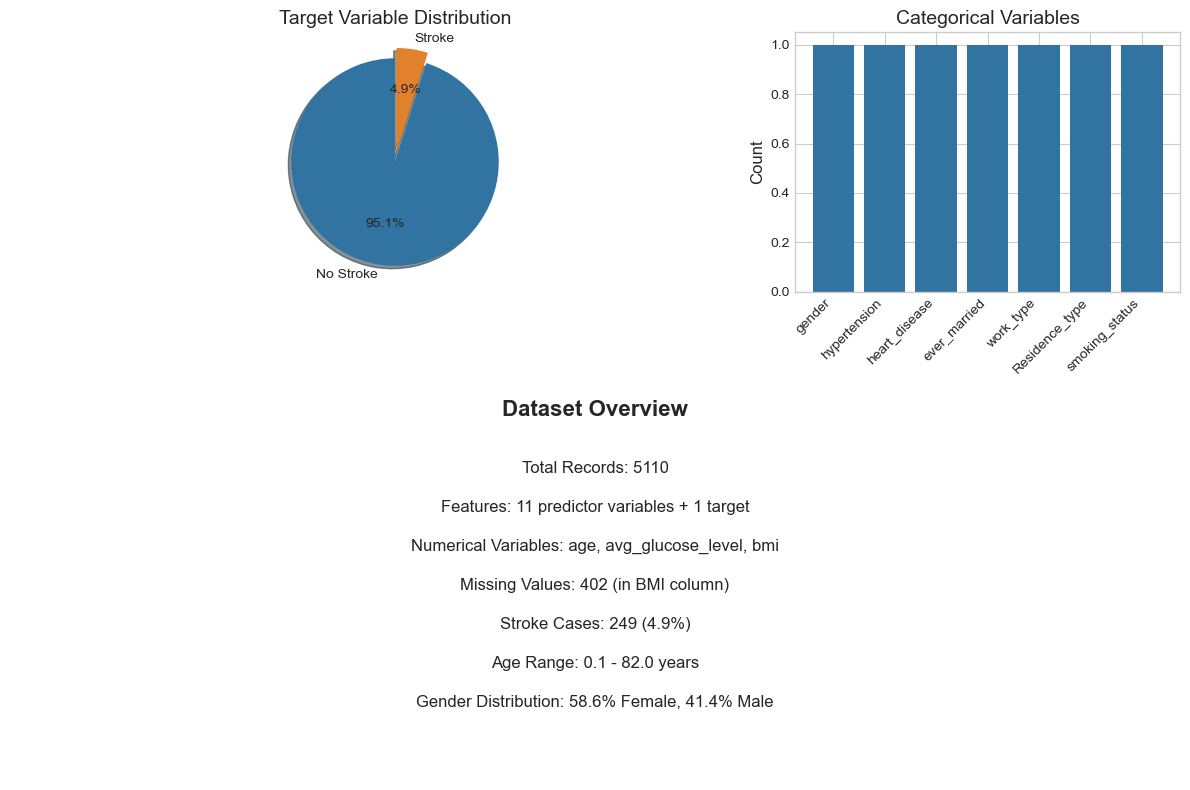

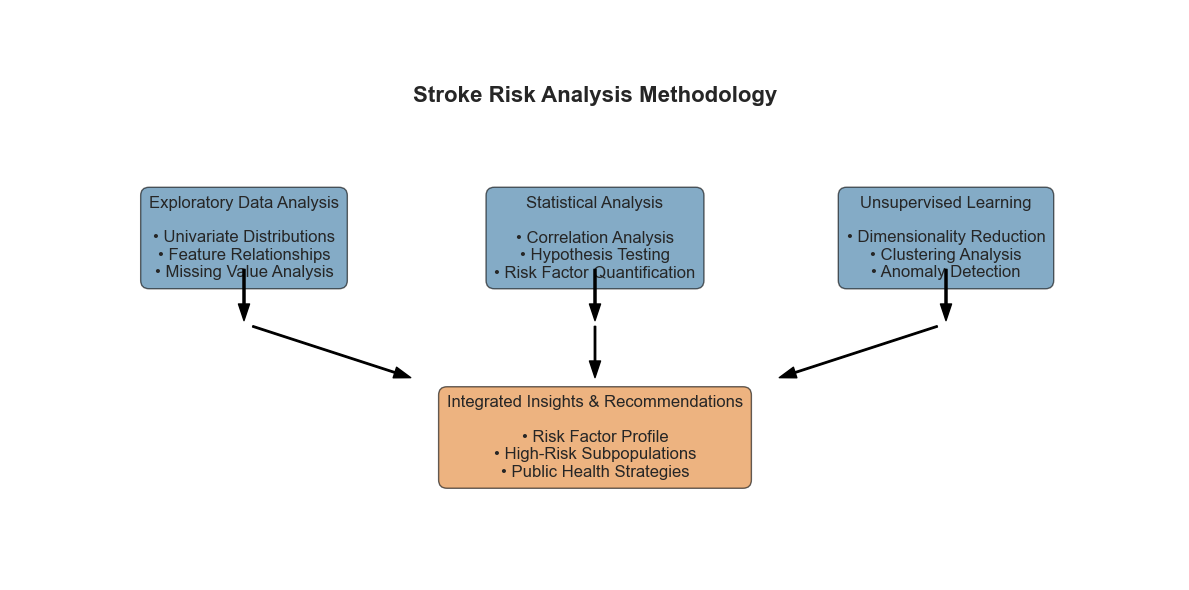


2. EXPLORATORY DATA ANALYSIS


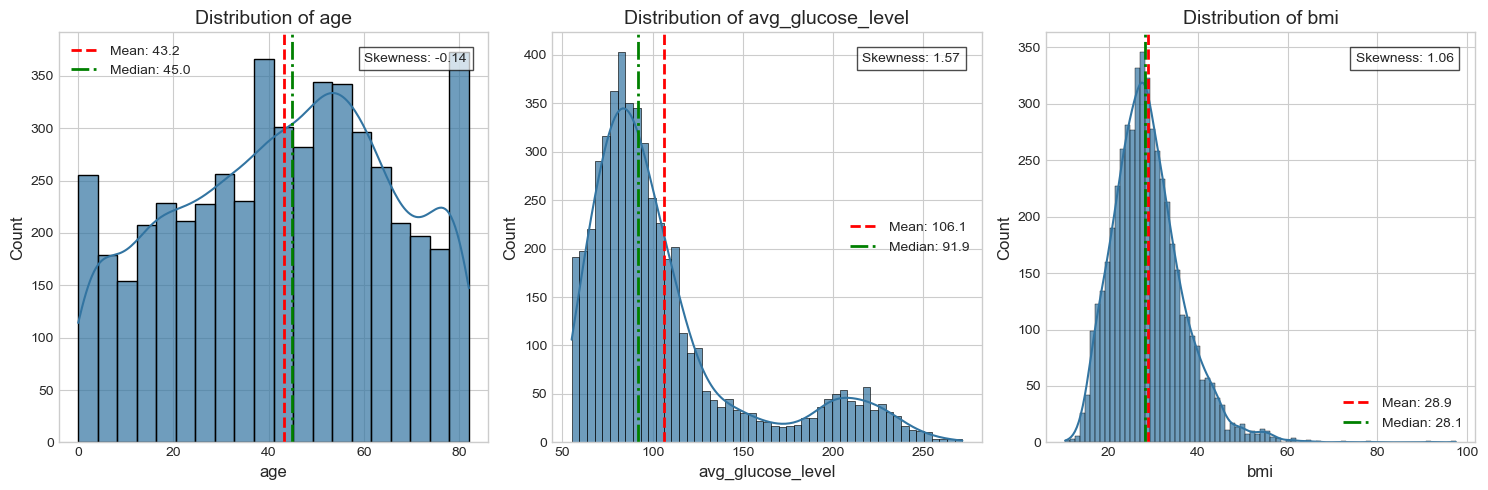

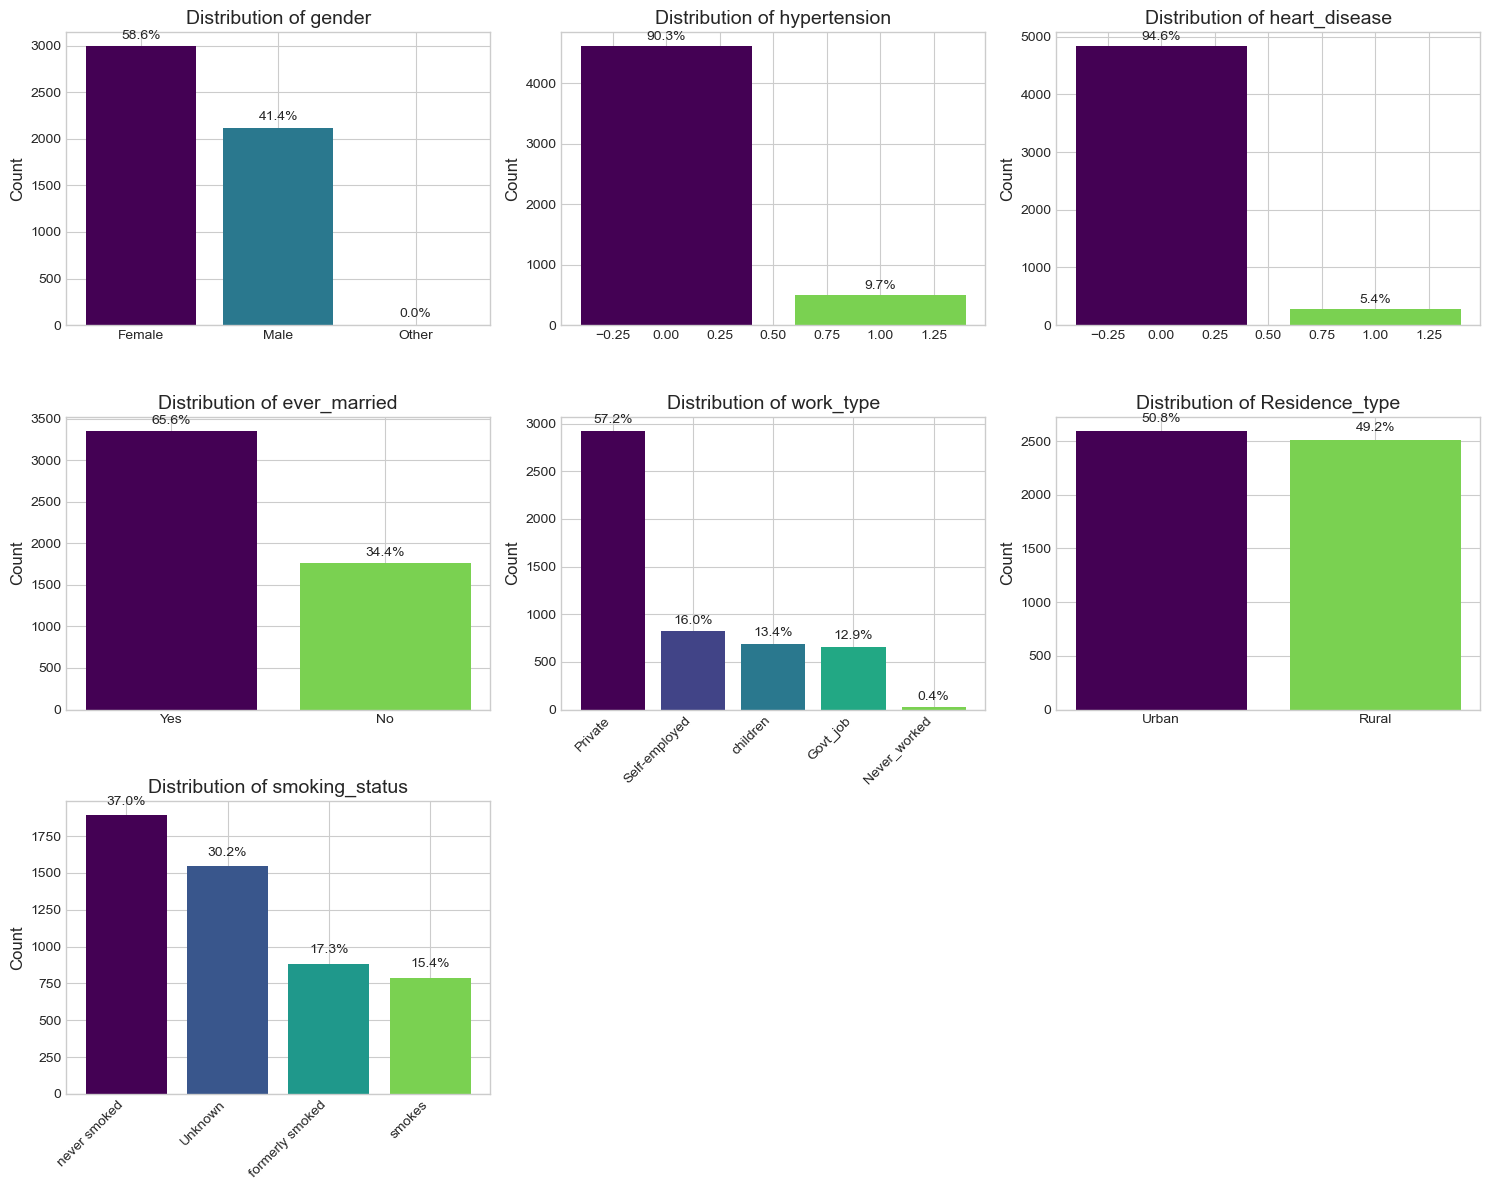

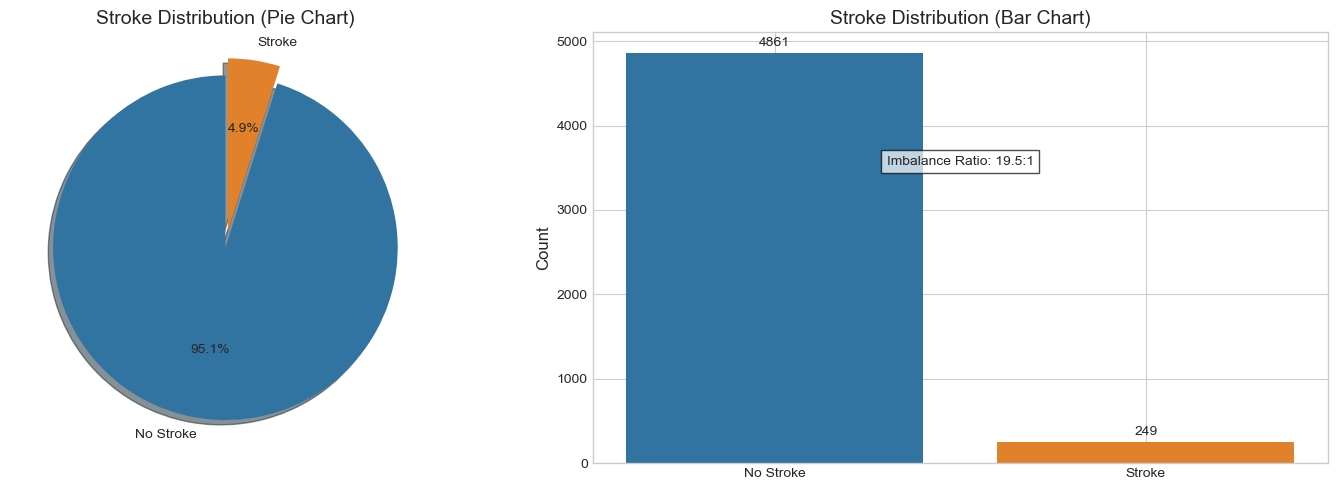

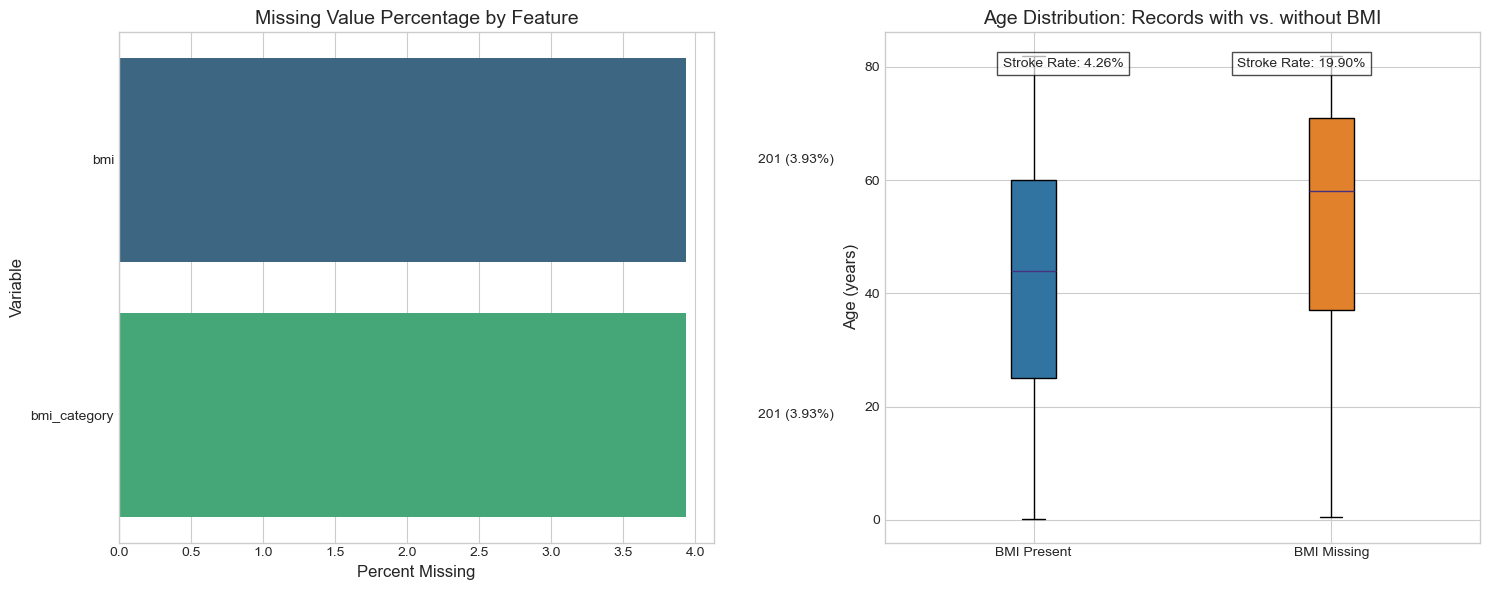


3. STATISTICAL ANALYSIS


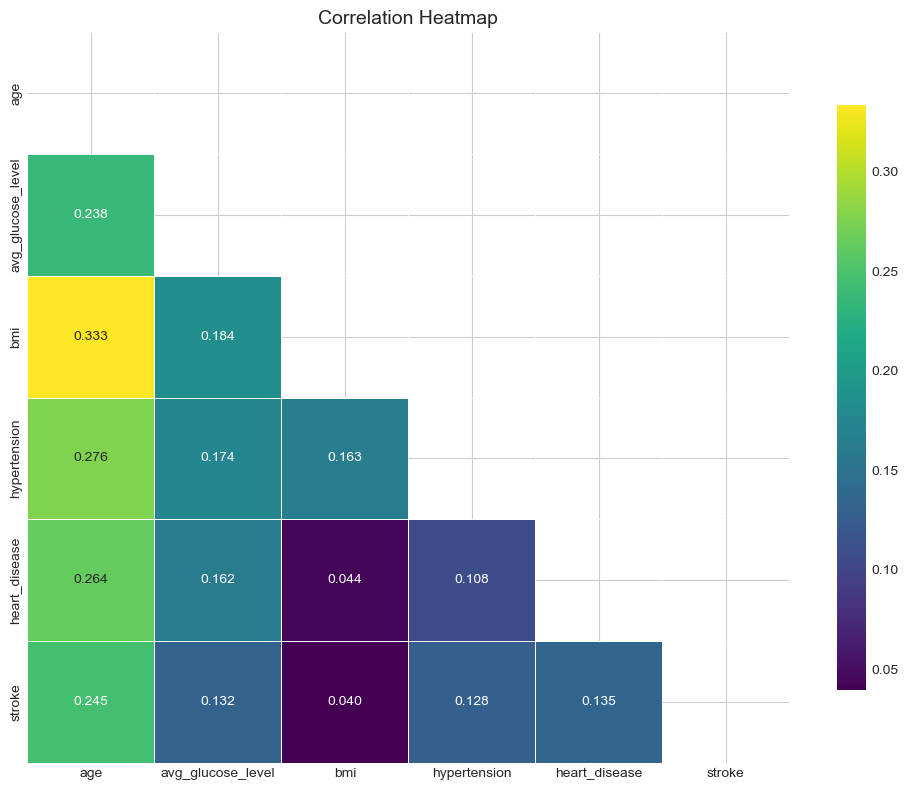

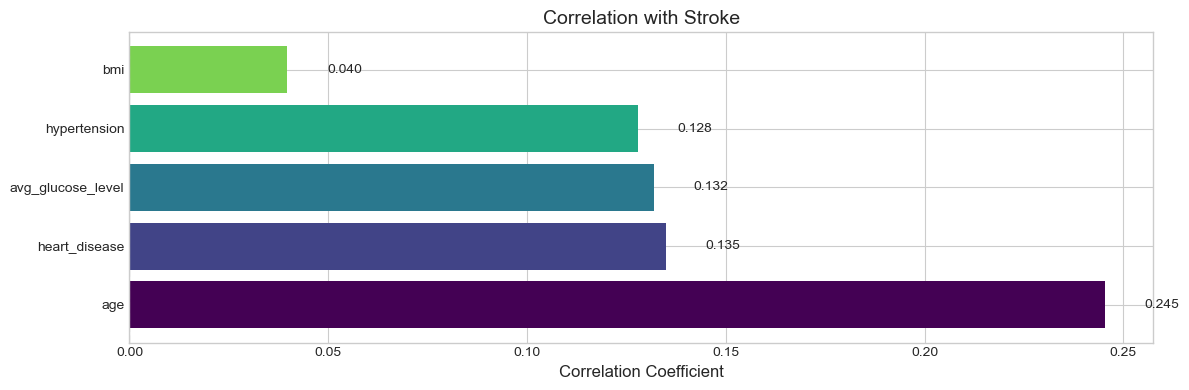

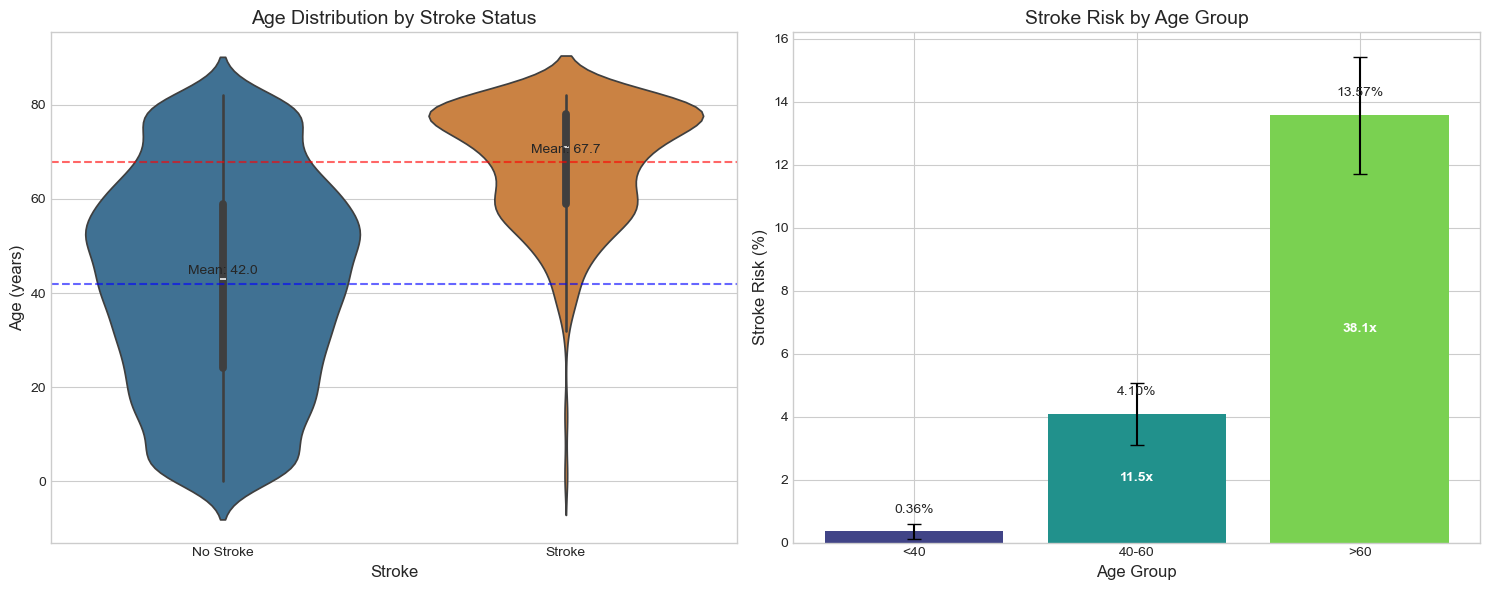

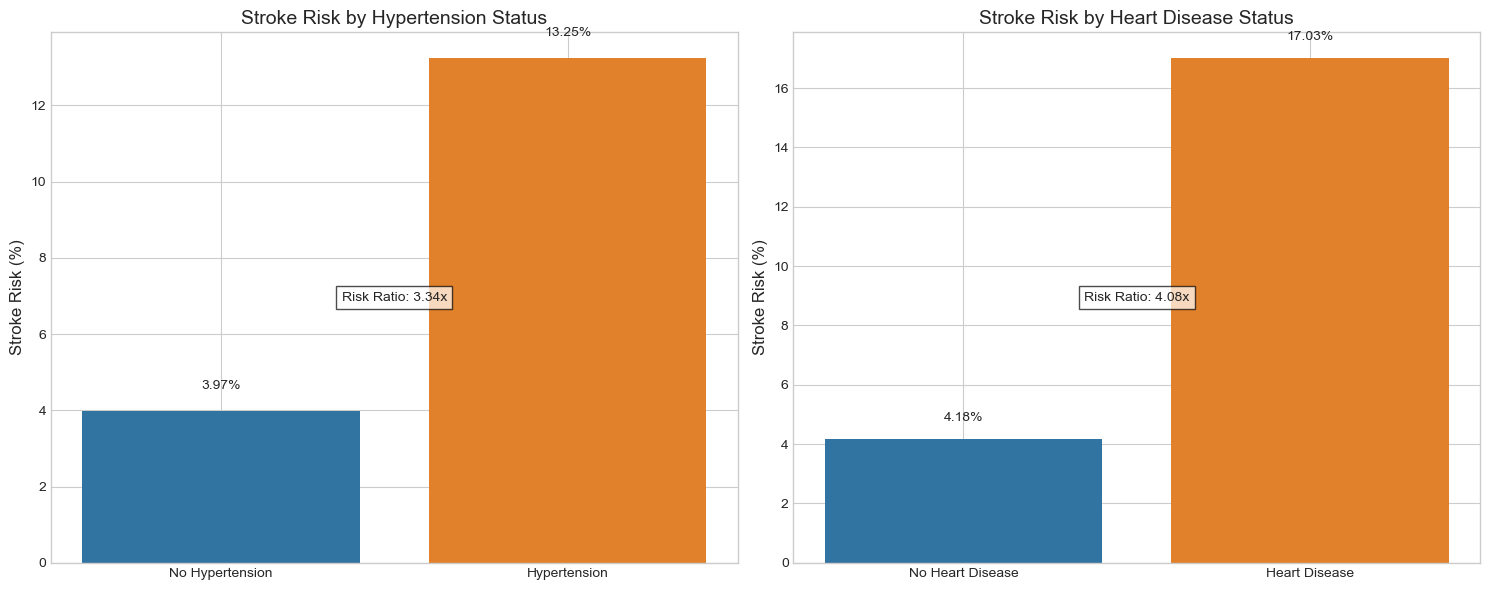

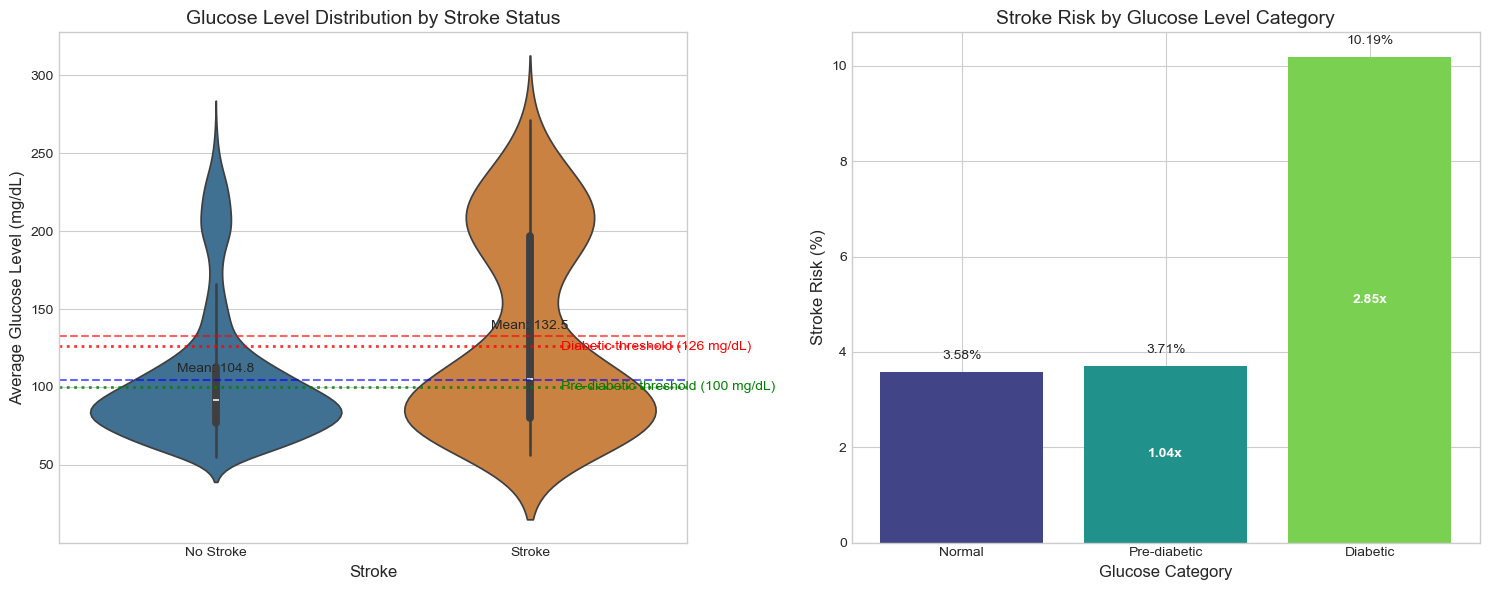

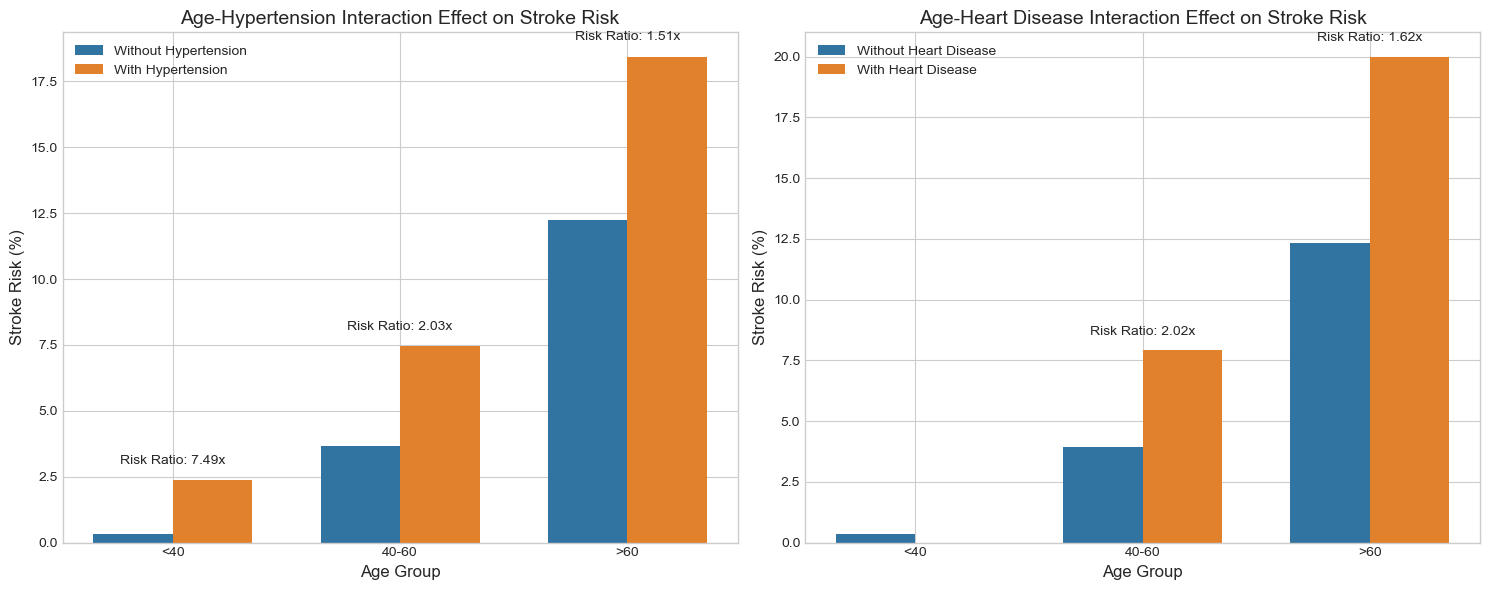

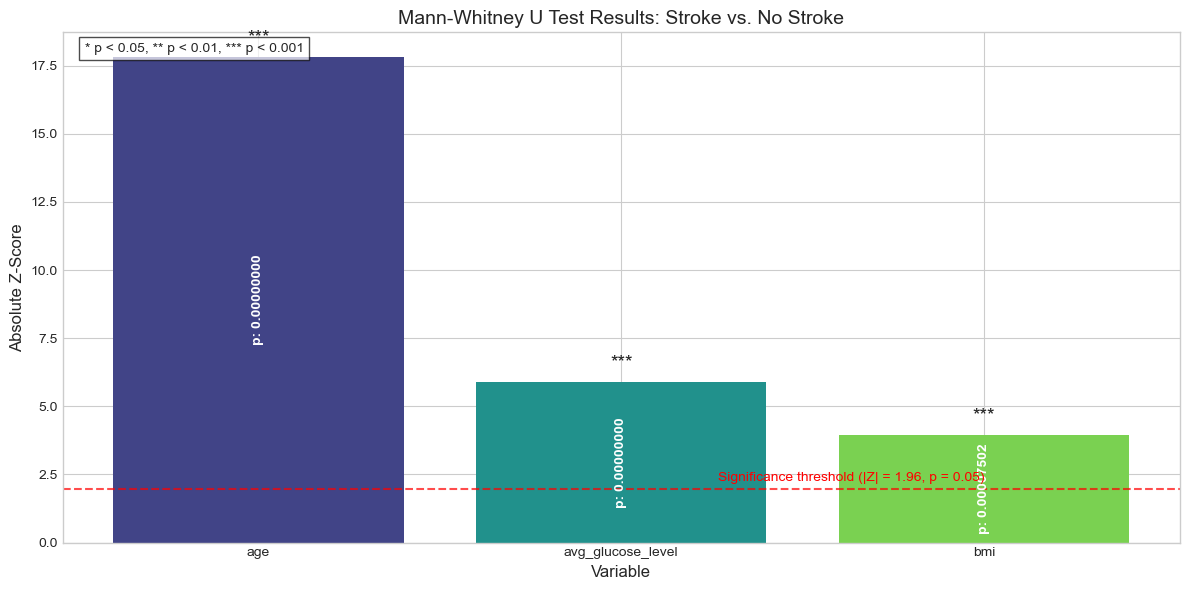


4. UNSUPERVISED LEARNING


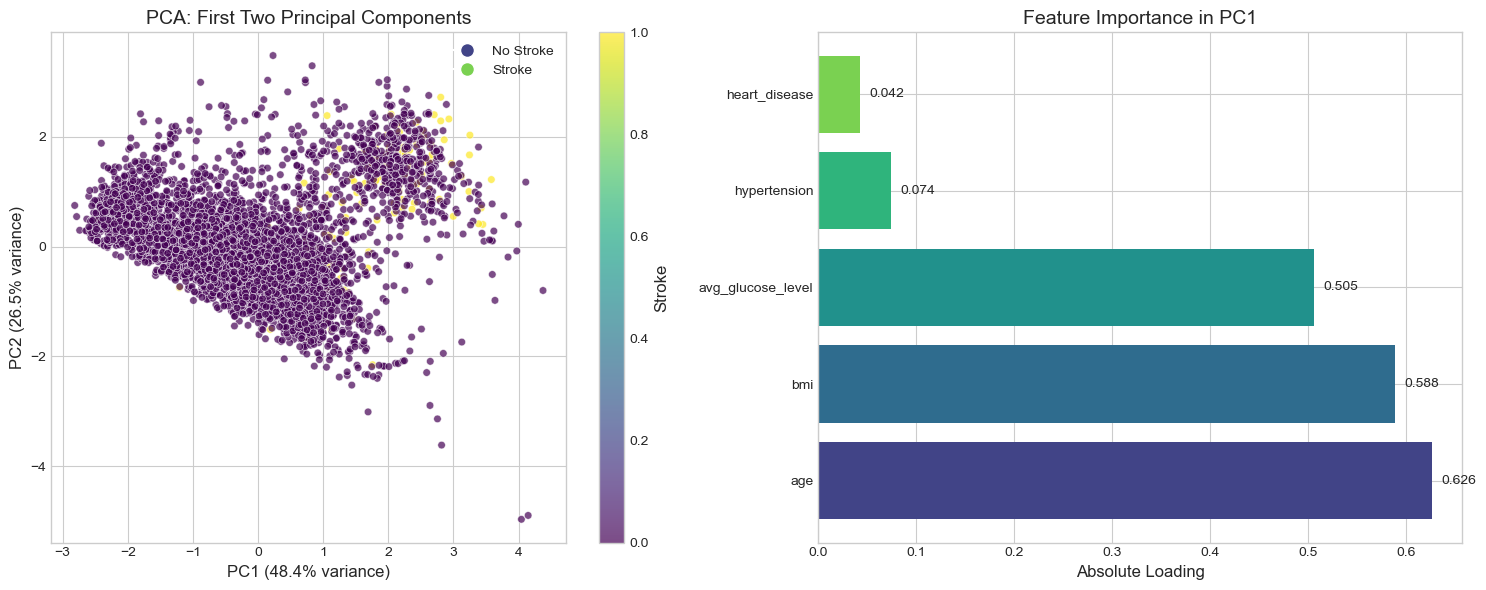

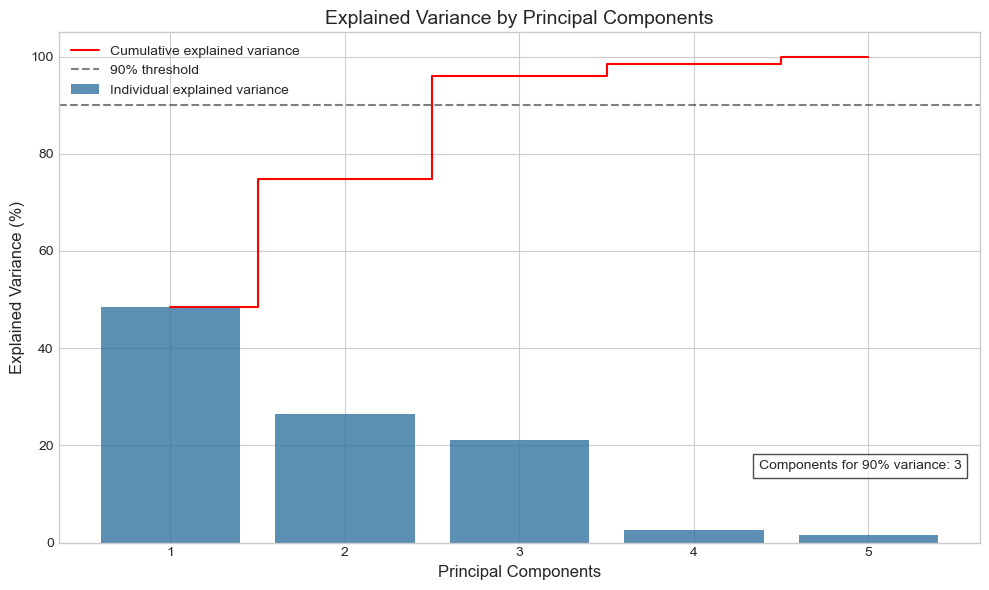

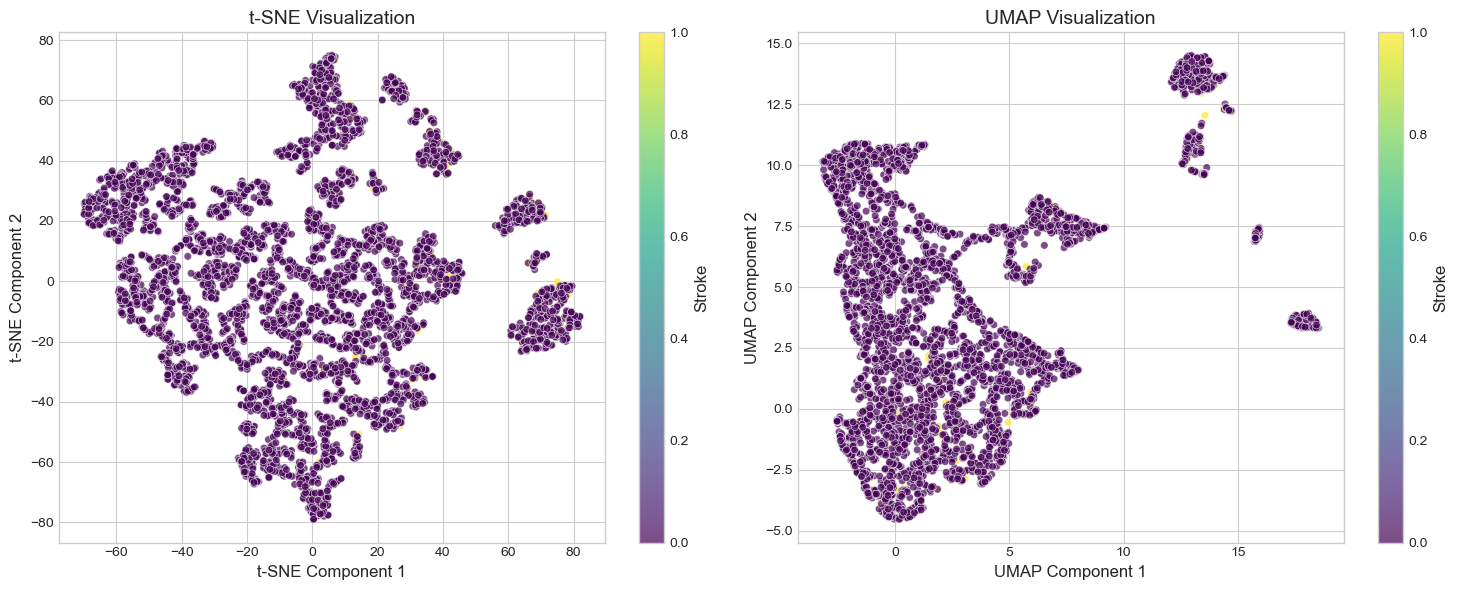

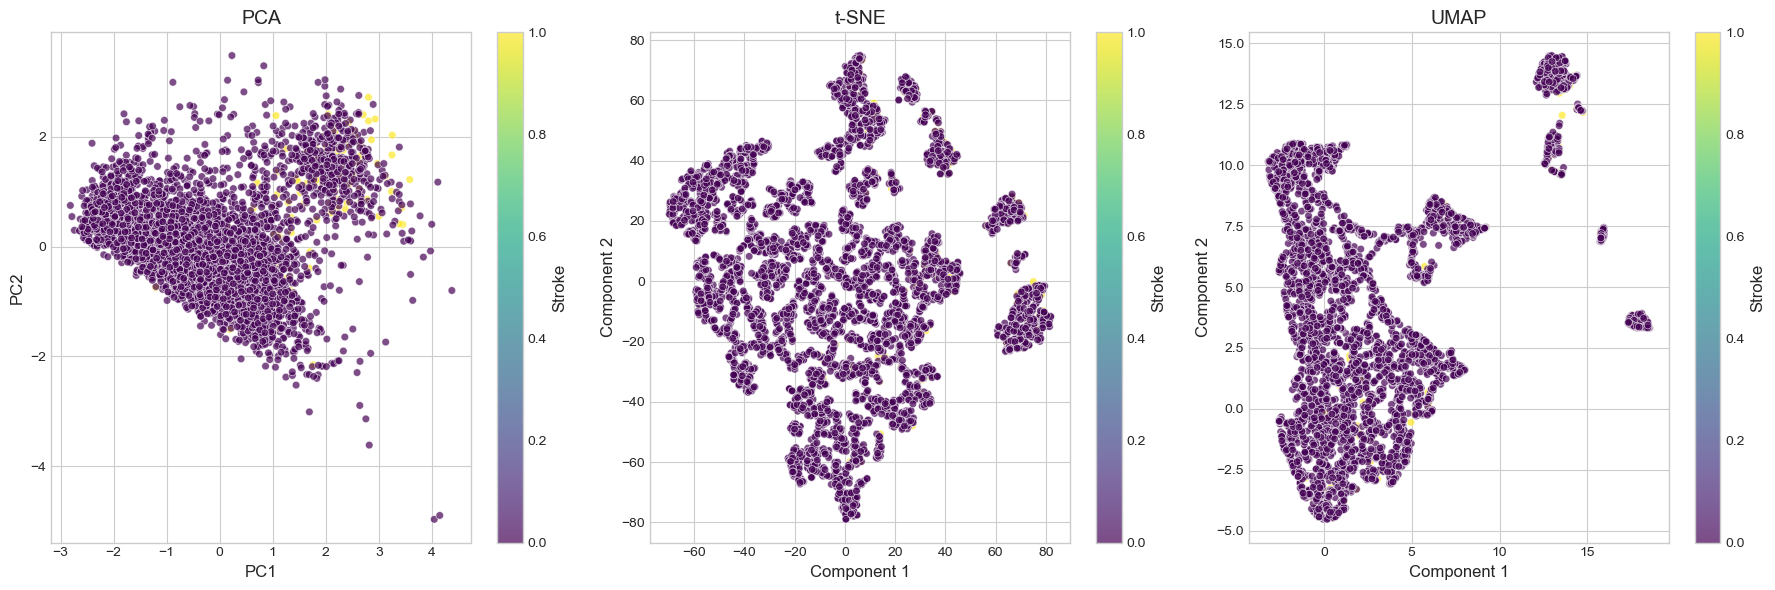

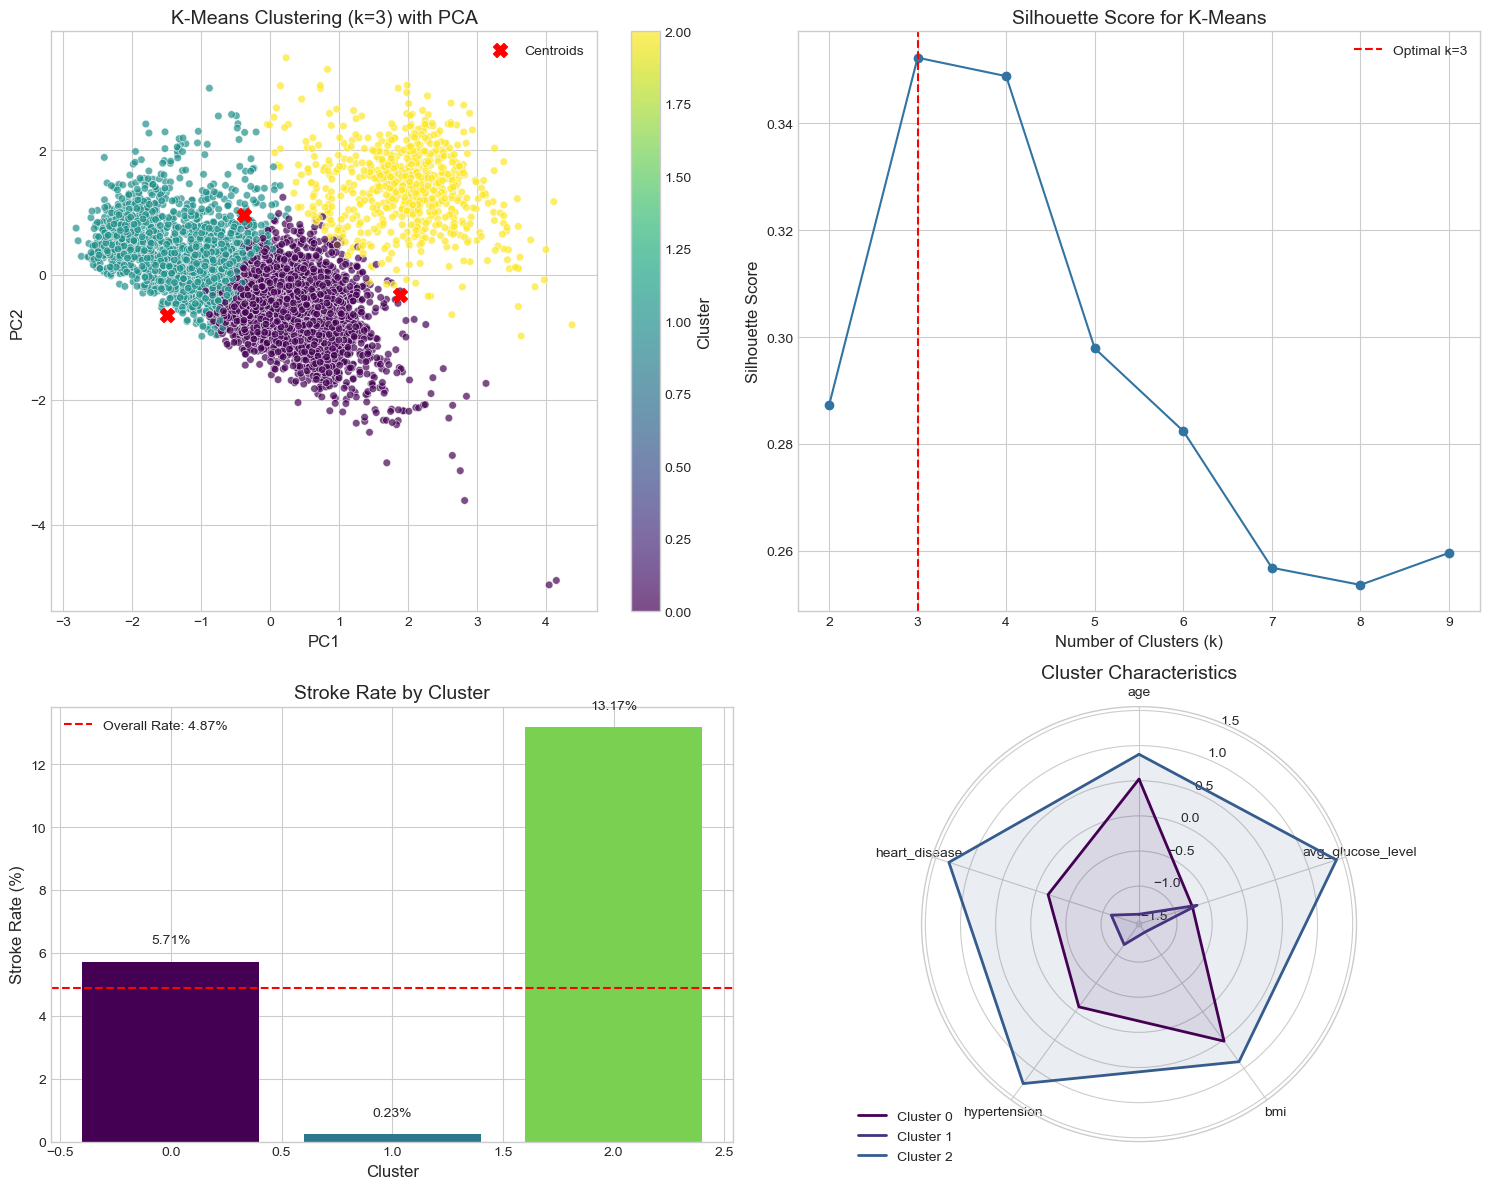

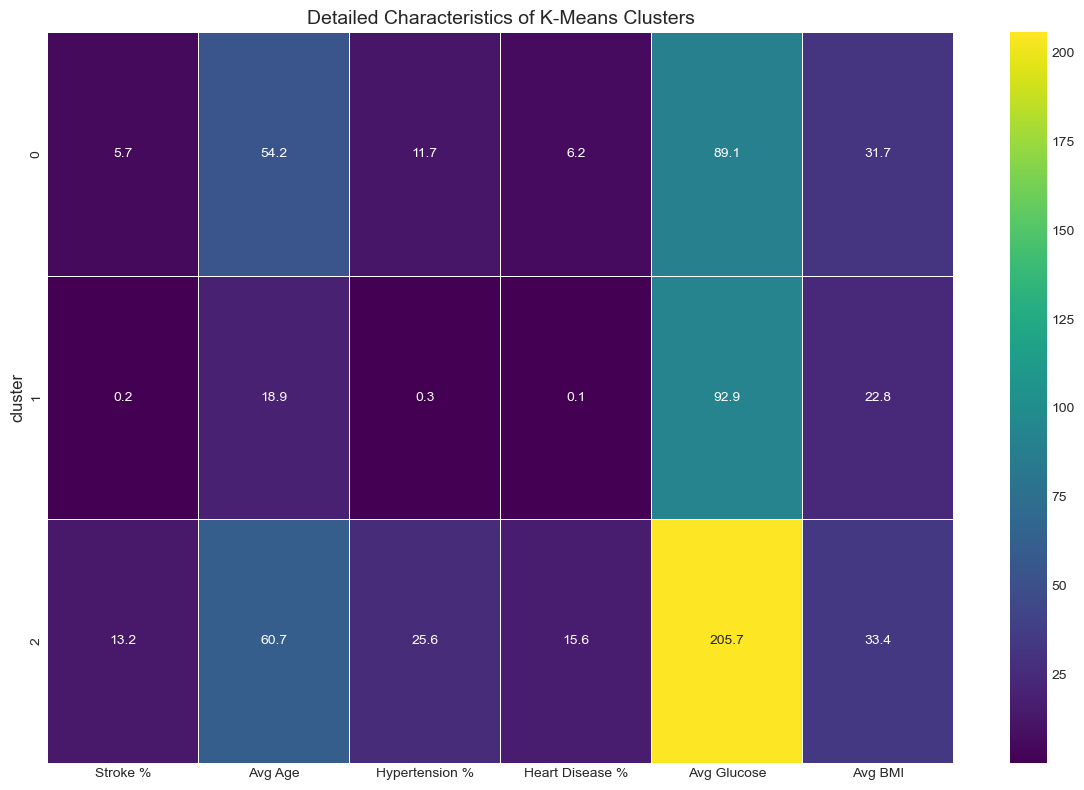

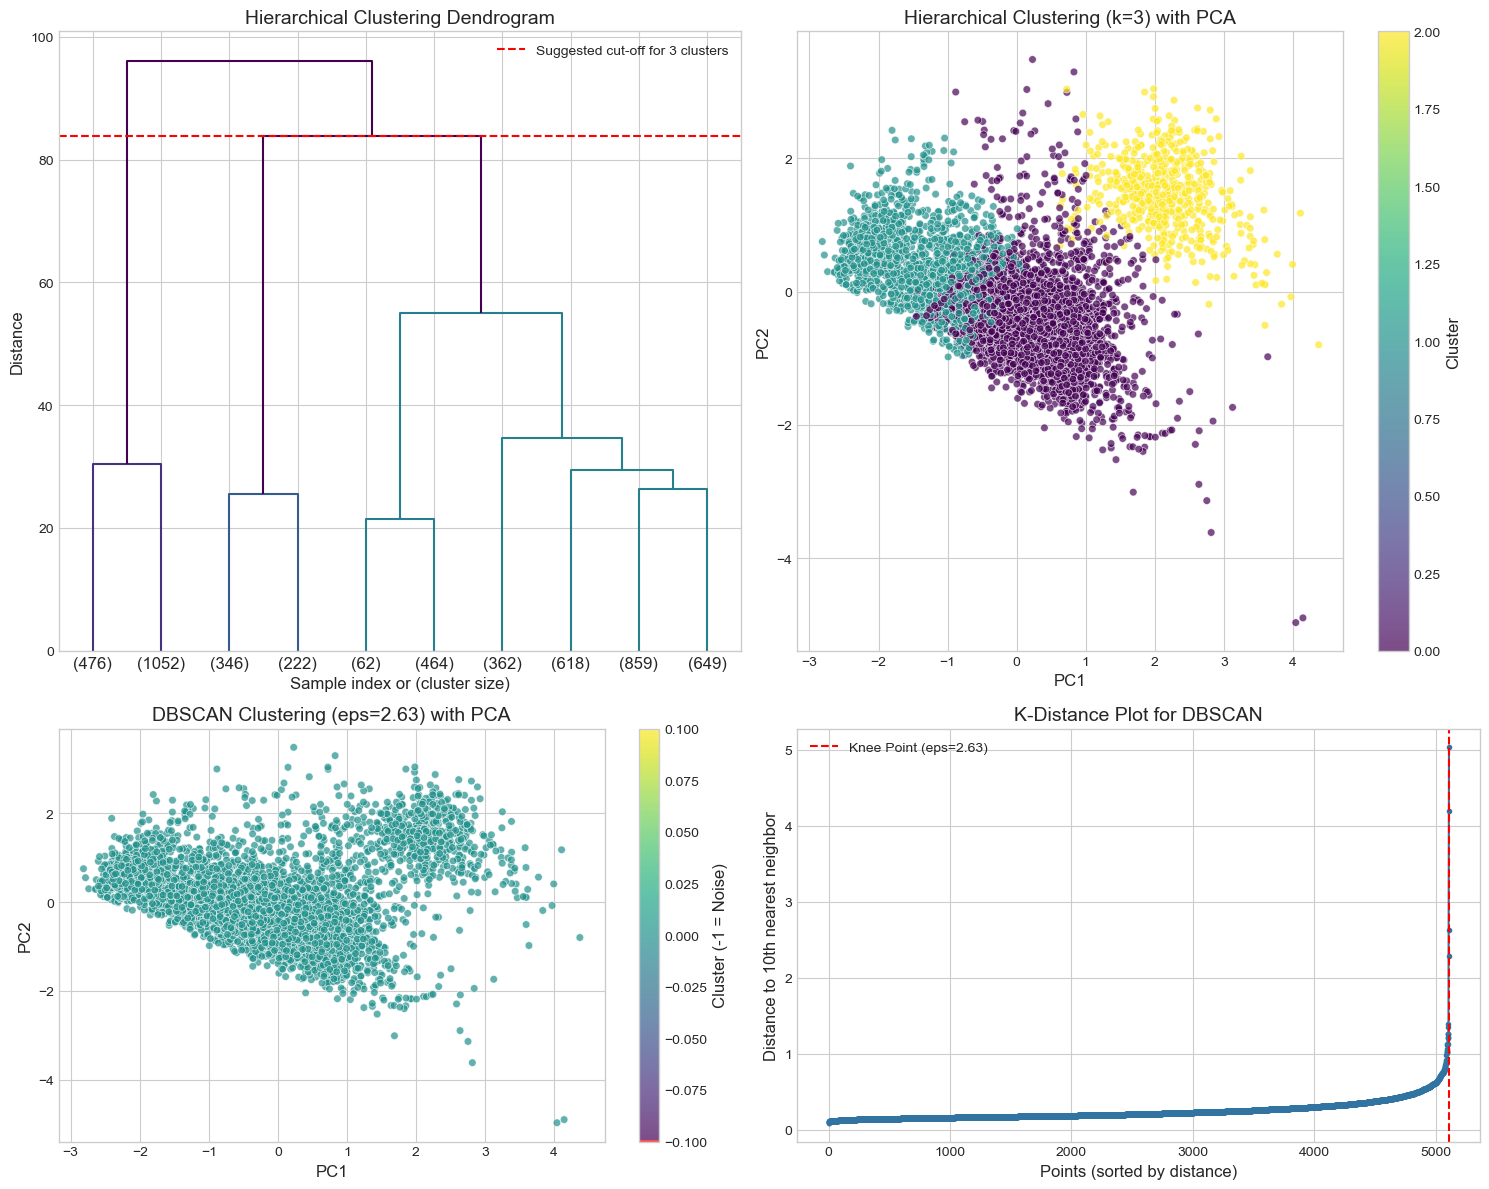

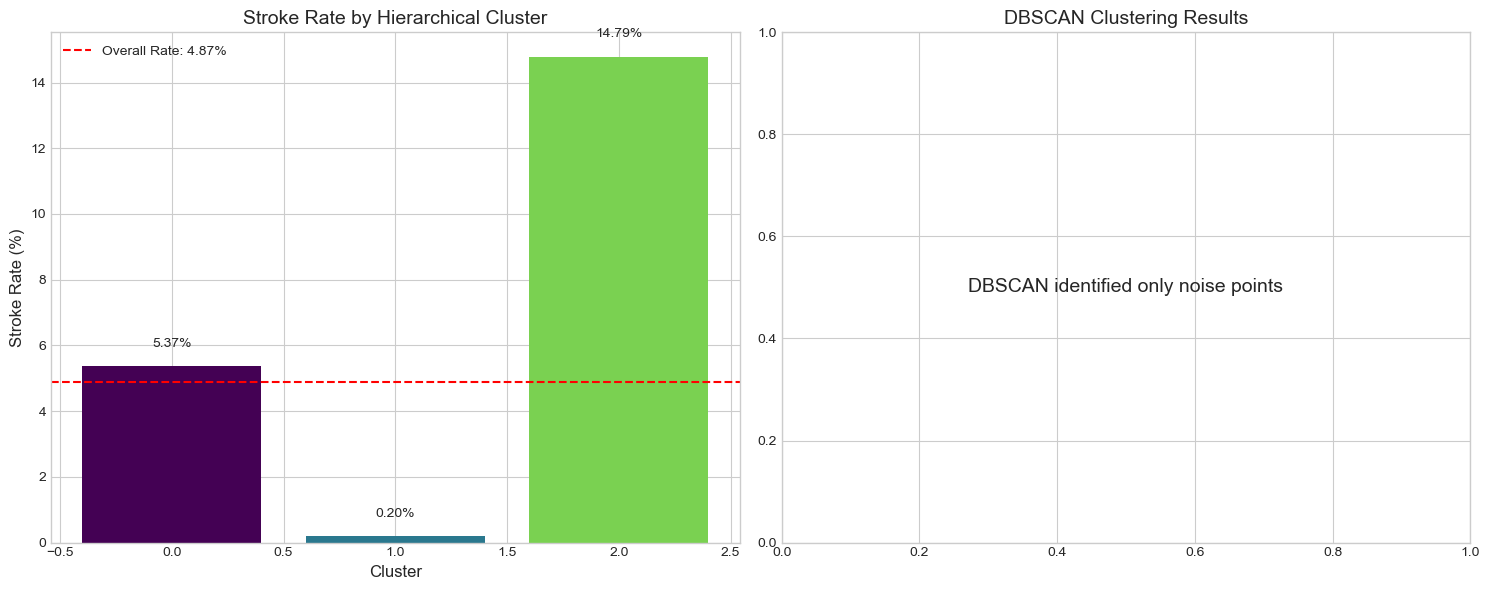

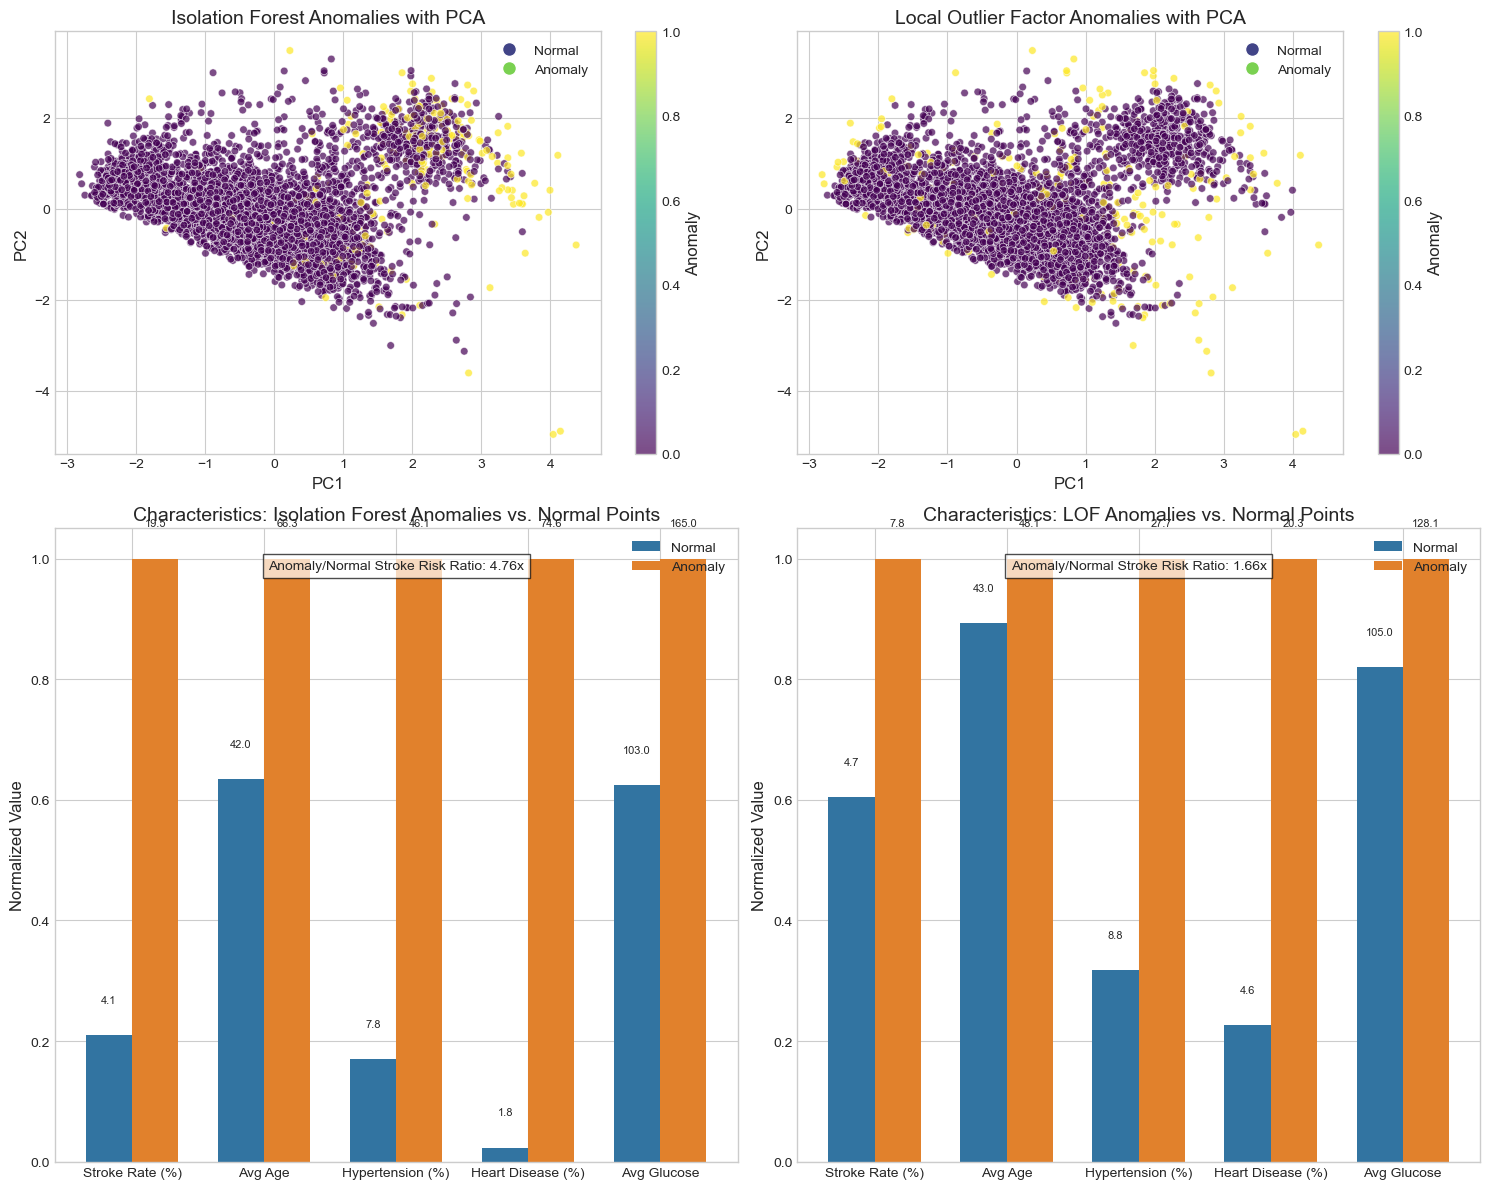

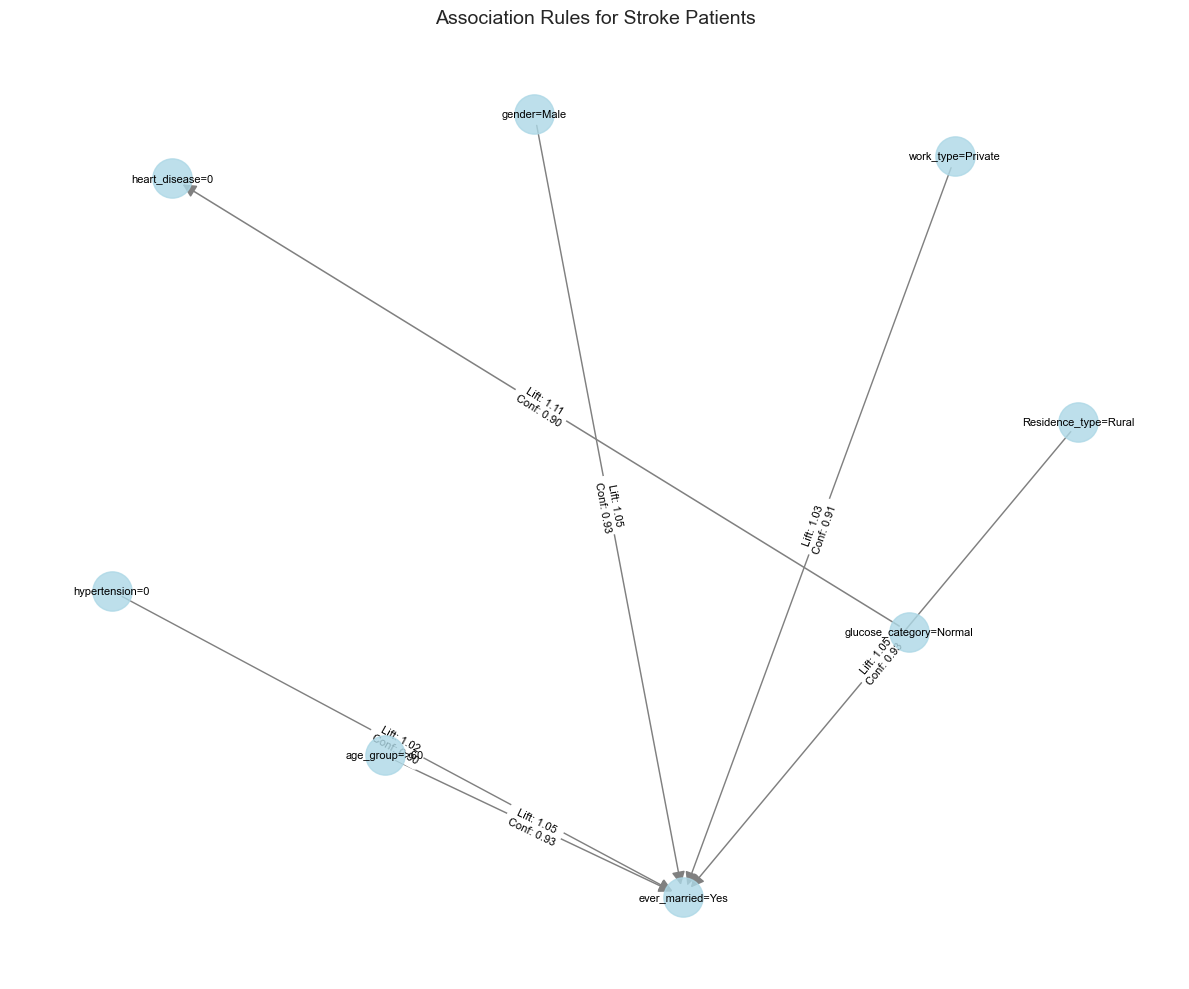


5. KEY TAKEAWAYS


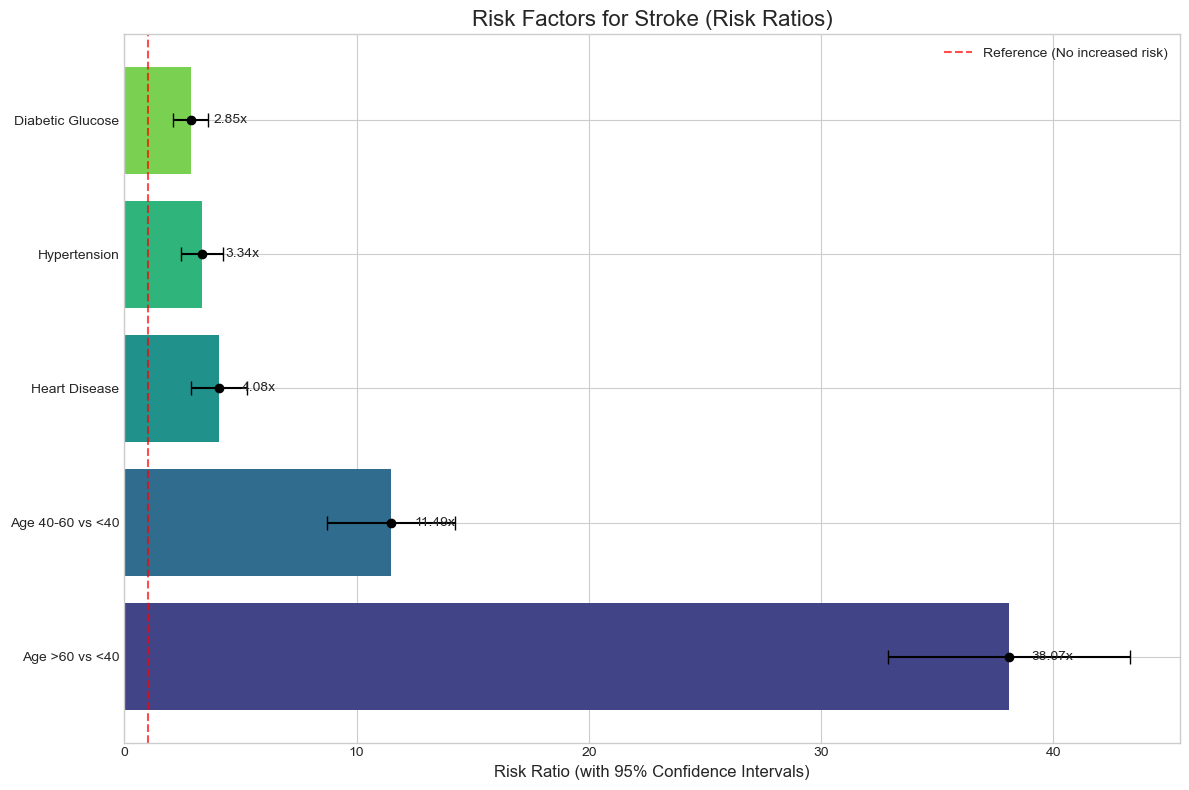

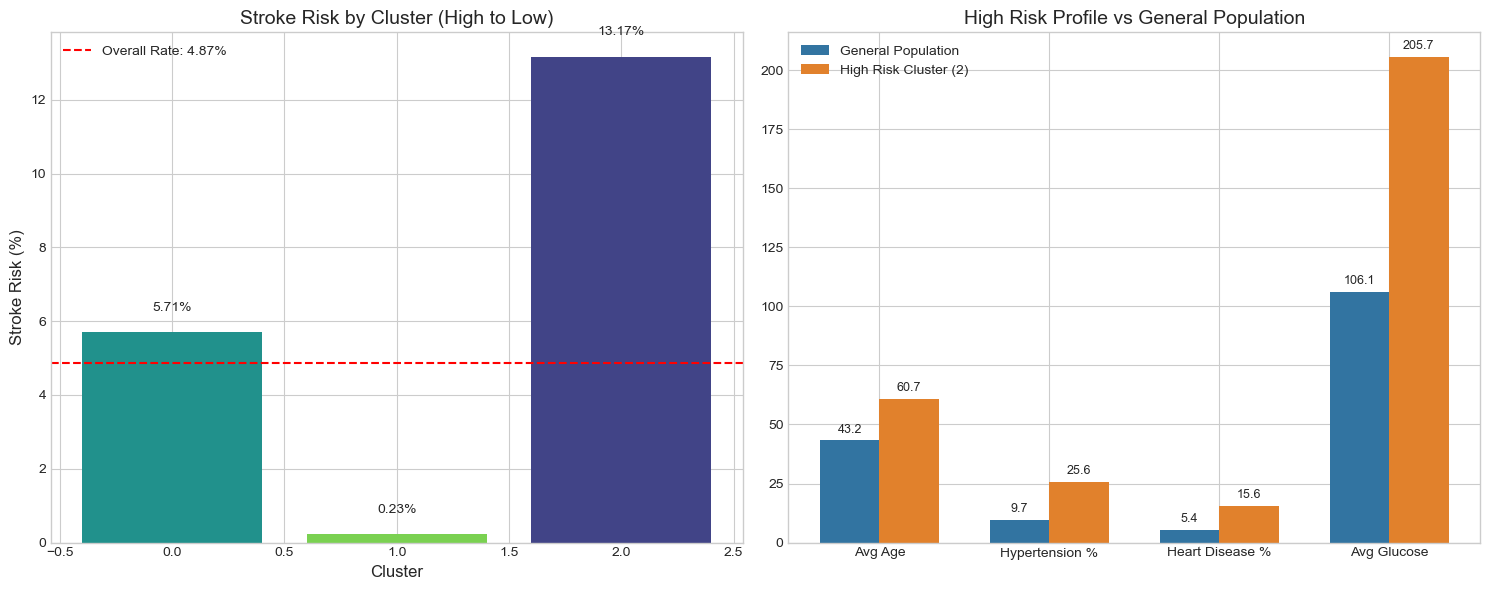

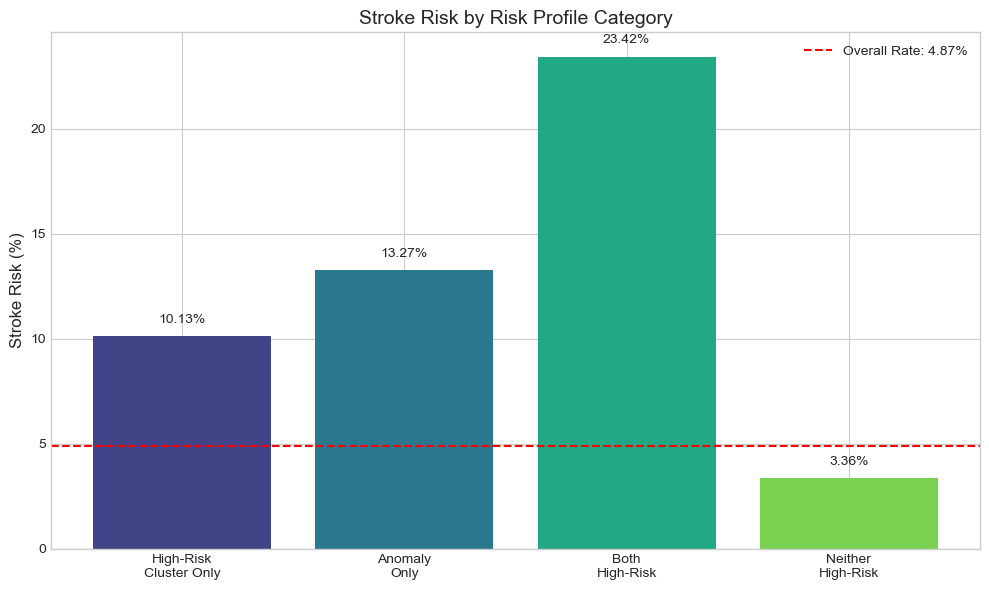

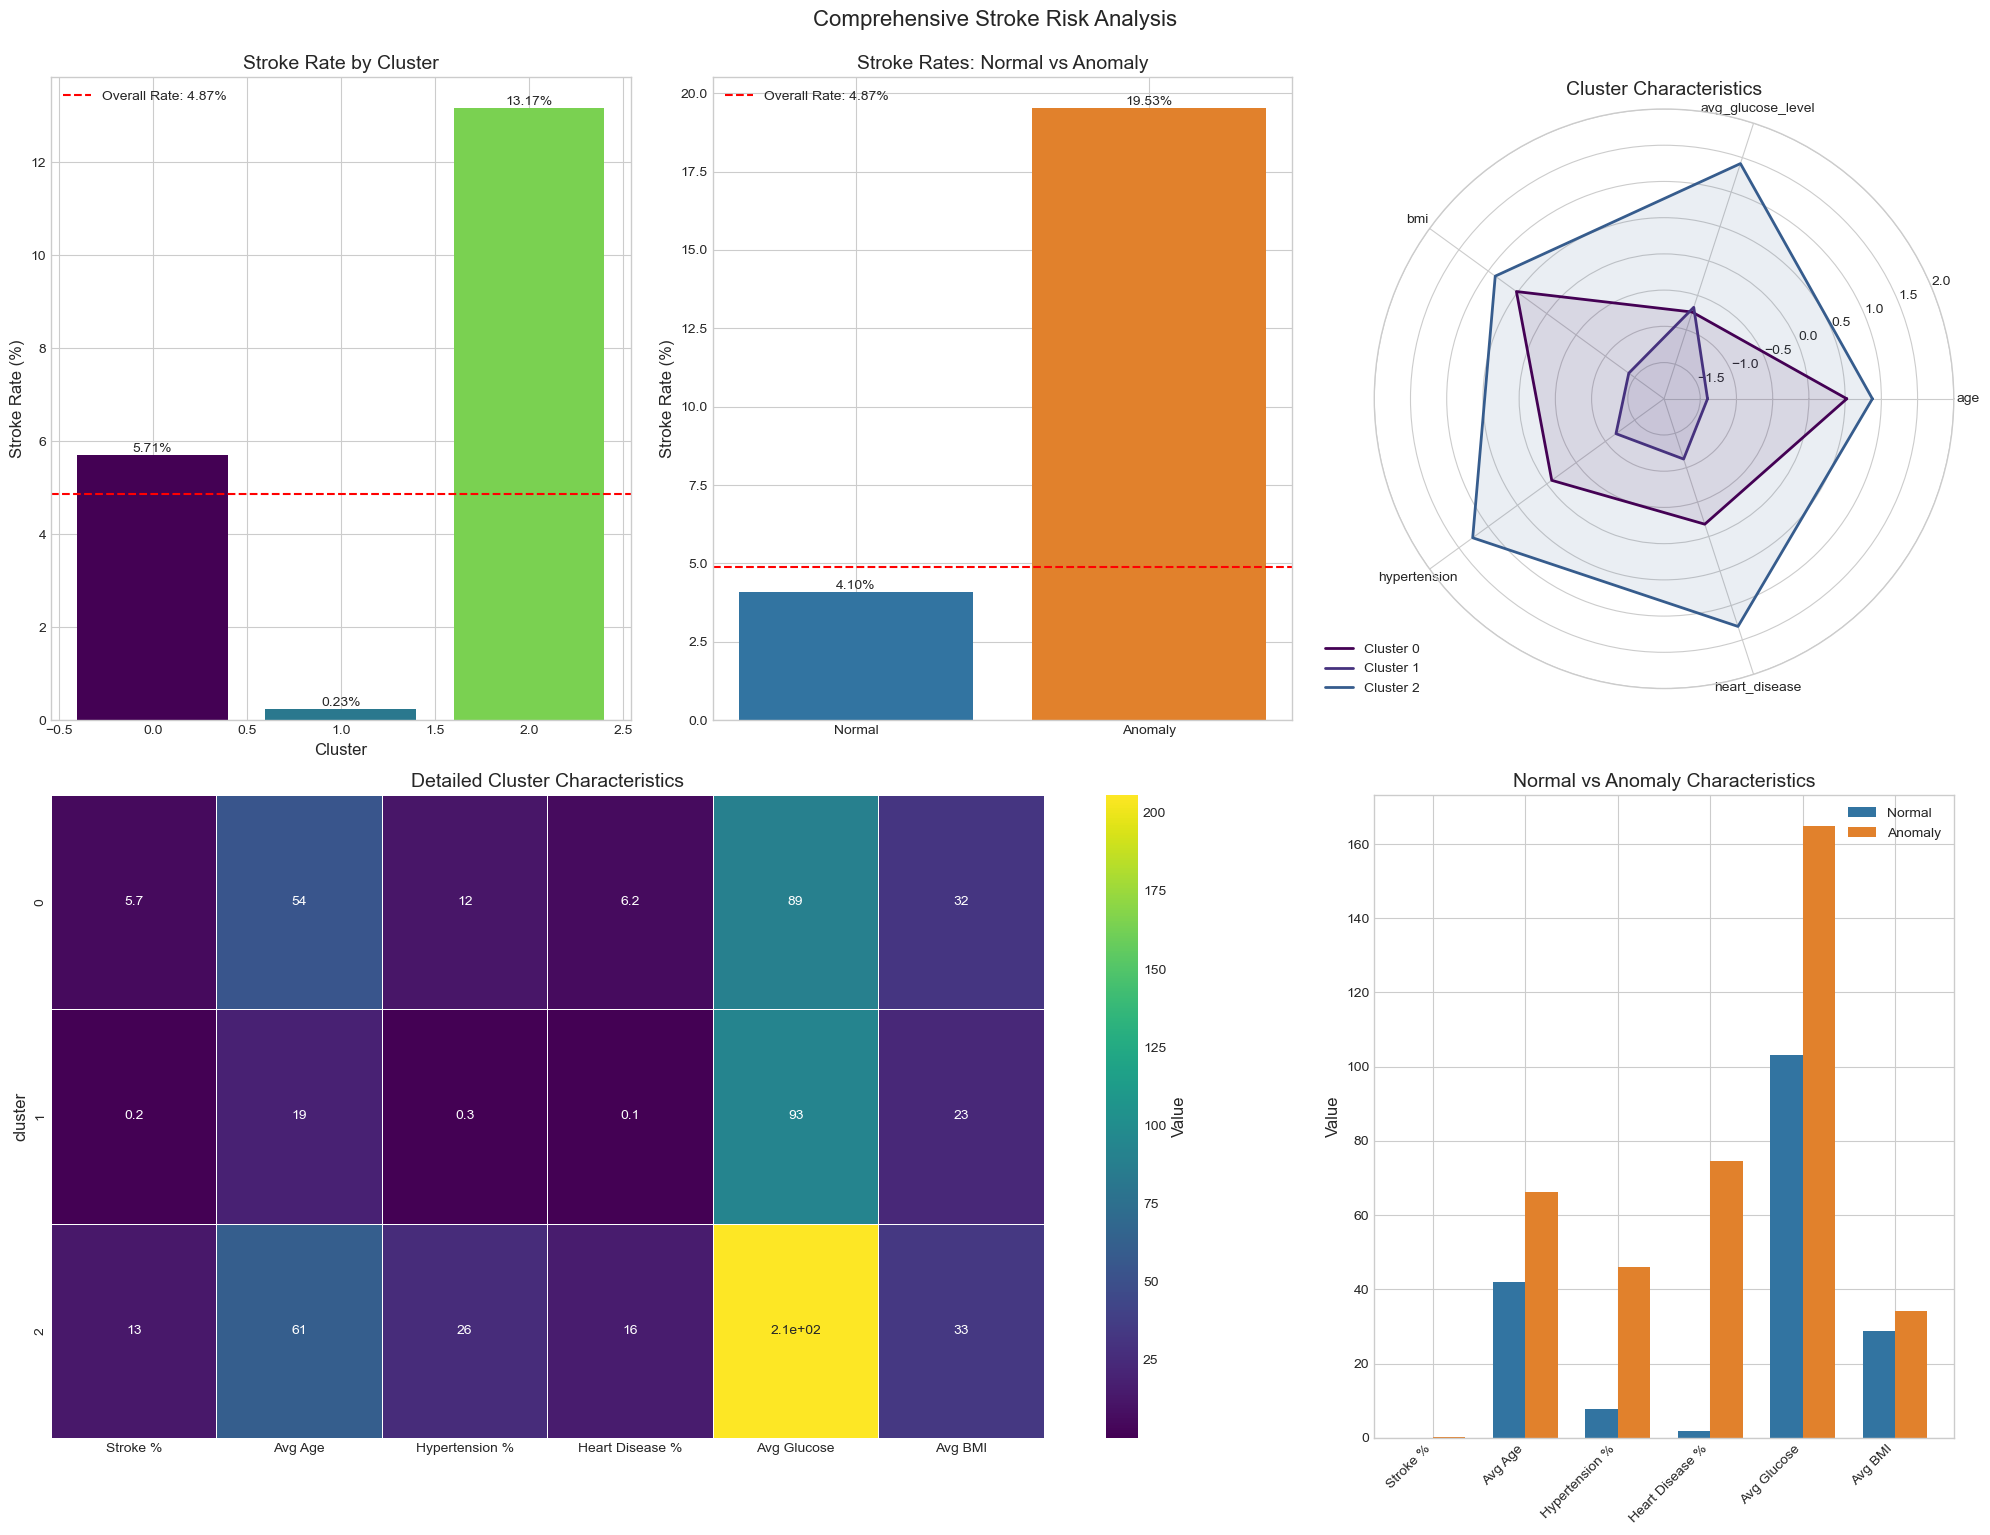


All visualizations completed successfully!


In [12]:
def main():
    """Main function to run visualizations"""
    print("Loading and preprocessing data...")
    # Load data
    df = load_data('C://Users//Nikhil//Desktop/Stroke Prediction//healthcare-dataset-stroke-data.csv')
    
    # Impute missing values
    df_imputed = impute_missing_values(df)
    
    print("\n1. INTRODUCTION")
    plot_dataset_overview(df)
    plot_methodology_flowchart()
    
    print("\n2. EXPLORATORY DATA ANALYSIS")
    plot_numerical_distributions(df)
    plot_categorical_distributions(df)
    plot_stroke_distribution(df)
    plot_missing_value_analysis(df)
    
    print("\n3. STATISTICAL ANALYSIS")
    plot_correlation_heatmap(df_imputed)
    plot_age_stroke_relationship(df_imputed)
    plot_medical_conditions_stroke_risk(df_imputed)
    plot_glucose_stroke_risk(df_imputed)
    plot_interaction_effects(df_imputed)
    plot_hypothesis_testing(df_imputed)
    
    print("\n4. UNSUPERVISED LEARNING")
    # Apply PCA and get PCA data
    pca_df = plot_pca_analysis(df_imputed)
    
    # Plot dimensionality reduction visualizations
    plot_nonlinear_dimensionality_reduction(df_imputed, pca_df)
    
    # Apply and visualize clustering
    df_clusters, optimal_k = apply_kmeans_clustering(df_imputed, pca_df)
    plot_hierarchical_dbscan_clustering(df_imputed, pca_df, optimal_k)
    
    # Apply and visualize anomaly detection
    df_iso, df_lof = plot_anomaly_detection(df_imputed, pca_df)
    
    # Visualize association rules
    plot_association_rules(df_imputed)
    
    print("\n5. KEY TAKEAWAYS")
    plot_risk_factor_profile(df_imputed)
    plot_high_risk_profiles(df_imputed, df_clusters, df_iso)
    plot_public_health_strategies(df_imputed, df_clusters)
    plot_summary_visualization(df_imputed, df_clusters, df_iso)
    
    print("\nAll visualizations completed successfully!")

if __name__ == "__main__":
    main()